In [1]:
import os
import numpy as np
from math import log
import itertools
import sys
from tqdm import tqdm

from torch.utils.data import DataLoader as DataLoader
from torch.utils.data.dataset import TensorDataset as TensorDataset

from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

import DRBin.utils as _vambtools

In [2]:
def make_dataloader(rpkm, tnf, batchsize=256, destroy=False, cuda=False):
    """Create a DataLoader and a contig mask from RPKM and TNF.

    The dataloader is an object feeding minibatches of contigs to the VAE.
    The data are normalized versions of the input datasets, with zero-contigs,
    i.e. contigs where a row in either TNF or RPKM are all zeros, removed.
    The mask is a boolean mask designating which contigs have been kept.

    Inputs:
        rpkm: RPKM matrix (N_contigs x N_samples)
        tnf: TNF matrix (N_contigs x N_TNF)
        batchsize: Starting size of minibatches for dataloader
        destroy: Mutate rpkm and tnf array in-place instead of making a copy.
        cuda: Pagelock memory of dataloader (use when using GPU acceleration)

    Outputs:
        DataLoader: An object feeding data to the VAE
        mask: A boolean mask of which contigs are kept
    """

    if not isinstance(rpkm, np.ndarray) or not isinstance(tnf, np.ndarray):
        raise ValueError('TNF and RPKM must be Numpy arrays')

    if batchsize < 1:
        raise ValueError('Minimum batchsize of 1, not {}'.format(batchsize))

    if len(rpkm) != len(tnf):
        raise ValueError('Lengths of RPKM and TNF must be the same')

    if not (rpkm.dtype == tnf.dtype == np.float32):
        raise ValueError('TNF and RPKM must be Numpy arrays of dtype float32')

    mask = tnf.sum(axis=1) != 0

    # If multiple samples, also include nonzero depth as requirement for accept
    # of sequences
    if rpkm.shape[1] > 1:
        depthssum = rpkm.sum(axis=1)
        mask &= depthssum != 0
        depthssum = depthssum[mask]

    if mask.sum() < batchsize:
        raise ValueError('Fewer sequences left after filtering than the batch size.')

    if destroy:
        rpkm = _vambtools.numpy_inplace_maskarray(rpkm, mask)
        tnf = _vambtools.numpy_inplace_maskarray(tnf, mask)
    else:
        # The astype operation does not copy due to "copy=False", but the masking
        # operation does.
        rpkm = rpkm[mask].astype(np.float32, copy=False)
        tnf = tnf[mask].astype(np.float32, copy=False)

    # If multiple samples, normalize to sum to 1, else zscore normalize
    if rpkm.shape[1] > 1:
        rpkm /= depthssum.reshape((-1, 1))
    else:
        _vambtools.zscore(rpkm, axis=0, inplace=True)

    # Normalize arrays and create the Tensors (the tensors share the underlying memory)
    # of the Numpy arrays
    _vambtools.zscore(tnf, axis=0, inplace=True)
    depthstensor = torch.from_numpy(rpkm)
    tnftensor = torch.from_numpy(tnf)

    # Create dataloader
    n_workers = 4 if cuda else 1
    dataset = TensorDataset(depthstensor, tnftensor)
    dataloader = DataLoader(dataset=dataset, batch_size=batchsize, drop_last=True,
                             shuffle=True, num_workers=n_workers, pin_memory=cuda)

    return dataloader, mask

In [3]:
### HYPERPARAMETERS

h_n = 512
s_l = 0.001
latent_dim = 32
h_n_d = h_n
n_epochs = 300
batch_size = 256
lr = 1e-3

depths=np.load('/home/maog/data/metahit/abundance.npz')
tnfs=np.loadtxt('/home/maog/data/metahit/tnfs.txt', dtype=np.float32)

depths=depths['arr_0']

In [4]:
path = '/home/maog/data/metahit'
input_len = depths.shape[1]+tnfs.shape[1]
num_samples=int(depths.shape[1])
## If available, use GPU leverage 
cuda = True if torch.cuda.is_available() else False

In [5]:
def reparameterization(mu, logvar):
    
    std = torch.exp(logvar / 2)
    sampled_z = Variable(Tensor(np.random.normal(0, 1, (mu.size(0), latent_dim))))  
    if cuda:
        sampled_z=sampled_z.cuda()
    z = sampled_z * std + mu
    return z

In [6]:
def calc_loss(depths_in, depths_out, tnf_in, tnf_out,num_samples,alpha=0.15):
# If multiple samples, use cross entropy, else use SSE for abundance 
    if num_samples > 1:
        # Add 1e-9 to depths_out to avoid numerical instability.
        ce = - ((depths_out + 1e-9).log() * depths_in).sum(dim=1).mean()
        ce_weight = (1-alpha) / log(num_samples)
        #print('CE=',ce*ce_weight)
    else:
        alpha = 0.50
        ce = (depths_out - depths_in).pow(2).sum(dim=1).mean()
        ce_weight = 1 - alpha
        #print('only 1 sample')
    #print(tnf_out,tnf_in)
    sse = (tnf_out - tnf_in).pow(2).sum(dim=1).mean()
    sse_weight =alpha/136
    #print('SEE=',sse*sse_weight)
    loss = ce * ce_weight + sse * sse_weight 
    #print(ce*ce_weight,sse*sse_weight)
    return loss, ce, sse

In [7]:
class Encoder(nn.Module):
    def __init__(self,h_n,latent_dim):
        super(Encoder, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(int(input_len), h_n),
            nn.BatchNorm1d(h_n),
            nn.LeakyReLU(),
            nn.Linear(h_n, h_n),
            nn.BatchNorm1d(h_n),
            nn.LeakyReLU(),
       )

        self.mu = nn.Linear(h_n, latent_dim)
        self.logvar = nn.Linear(h_n, latent_dim)# ????


    def forward(self,depths,tnfs):
        I=torch.cat((depths,tnfs),1)
        x = self.model(I)
        mu = self.mu(x)
        
        logvar = self.logvar(x)
        z = reparameterization(mu, logvar)
        return z


class Decoder(nn.Module):
    def __init__(self,h_n,latent_dim):
        super(Decoder, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, h_n),
            nn.BatchNorm1d(h_n),
            nn.LeakyReLU(),
            nn.Linear(h_n, h_n),
            nn.BatchNorm1d(h_n),
            nn.LeakyReLU(),
            nn.Linear(h_n, int(input_len)), 
        )

    def forward(self, z):
        reconstruction = self.model(z)
        
        Depths_out,tnf_out =(reconstruction[:,:num_samples],
                reconstruction[:,num_samples:])
        
        depths_out=F.softmax(Depths_out,dim=1)
        
        return reconstruction,depths_out,tnf_out


class Discriminator(nn.Module):
    def __init__(self,h_n_d,latent_dim):

        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(latent_dim, int(h_n_d)),
            nn.LeakyReLU(),
            nn.Linear(int(h_n_d), int(h_n_d/2)),
            nn.LeakyReLU(),
            nn.Linear(int(h_n_d/2), 1),
            nn.Sigmoid(),
        )

    def forward(self, z):
        validity = self.model(z)
        return validity

In [8]:
###   LOSS
# Use binary cross-entropy loss
adversarial_loss = torch.nn.BCELoss()
#adversarial_loss = torch.nn.BCEWithLogitsLoss()

# Initialize generator and discriminator
encoder = Encoder(h_n,latent_dim)
decoder = Decoder(h_n,latent_dim)
discriminator = Discriminator(h_n_d,latent_dim)

if cuda:
    encoder.cuda()
    decoder.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()
    #reconstruction_loss.cuda()

# Optimizers
optimizer_G = torch.optim.Adam(
    itertools.chain(encoder.parameters(), decoder.parameters()))

optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr )
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [9]:
# ----------
#  Training
# ----------
def train_epoch(dataloader,epoch_i,epoch_T,G_loss,D_r_loss,D_f_loss,epoch_len):
    
    for i, (depths_in, tnfs_in) in enumerate(dataloader): 
        imgs=torch.cat((depths_in,tnfs_in),dim=1)
        # Adversarial ground truths
        valid = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = Variable(imgs.type(Tensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        #encoded_imgs = encoder(real_imgs)
        if cuda == True:
            depths_in=depths_in.cuda()
            tnfs_in=tnfs_in.cuda()

        encoded_imgs = encoder(depths_in,tnfs_in)

        decoded_imgs,depths_out,tnfs_out= decoder(encoded_imgs)

        # Loss measures generator's ability to fool the discriminator
       
        vae_loss,ce,sse = calc_loss(depths_in, depths_out, tnfs_in, tnfs_out,num_samples,alpha=0.15)
         
        g_loss = s_l * adversarial_loss(discriminator(encoded_imgs), valid) + (1-s_l) * vae_loss

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Sample noise as discriminator ground truth
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(z), valid)
        fake_loss = adversarial_loss(discriminator(encoded_imgs.detach()), fake)
        d_loss = 0.15 * (real_loss + fake_loss)

        d_loss.backward()
        optimizer_D.step()
        #print(
        #    "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f] [CE: %f] [SSE: %f]  "
        #    % (epoch_i, n_epochs, i, epoch_len, d_loss.item(), g_loss.item(),ce,sse))
        
        if i % 250 == 0:
            print(
                "[Epoch %d/%d] [Batch %d/%d] [D real loss: %f] [D fake loss: %f] [G loss: %f] [CE: %f] [SSE: %f]  "
                % (epoch_i, n_epochs, i, epoch_len, real_loss.item(),fake_loss.item(), g_loss.item(),ce,sse))
        
        G_loss.append(float(g_loss.detach()))
        D_r_loss.append(float(real_loss.detach()))
        D_f_loss.append(float(fake_loss.detach()))       #batches.append(batches_done)
     
     
    return G_loss,D_r_loss,D_f_loss

In [10]:
def train_model(Path=path,batchsize=batch_size,n_epochs=n_epochs,batchsteps=[25, 75, 150, 300]):
    G_loss=[]
    D_loss=[]
    
    print('Training model\n')

    epochs_num=len(make_dataloader(depths,tnfs,batchsize,cuda=cuda)[0])

    for epoch in tqdm(range(n_epochs)):
        print('\n\n EPOCH:',epoch,'\n\n')
        if epoch in batchsteps:
            batchsize *=2
            epochs_num=len(make_dataloader(depths,tnfs,batchsize,cuda=cuda)[0])
        if epoch == 0:
            G_loss=[]
            D_loss=[]
            D_r_loss=[]
            D_f_loss=[]

            G_loss_F,D_r_loss_F,D_f_loss_F=train_epoch(dataloader=make_dataloader(depths,tnfs,batchsize,cuda=cuda)[0],epoch_i=epoch,epoch_T=n_epochs,G_loss=G_loss,D_r_loss=D_r_loss,D_f_loss=D_f_loss,epoch_len=epochs_num)
        else:
            G_loss_i,D_r_loss_i,D_f_loss_i=train_epoch(dataloader=make_dataloader(depths,tnfs,batchsize,cuda=cuda)[0],epoch_i=epoch,epoch_T=n_epochs,G_loss=G_loss_F,D_r_loss=D_r_loss_F,D_f_loss=D_f_loss_F,epoch_len=epochs_num)
            G_loss_F,D_r_loss_F,D_f_loss_F=G_loss_i,D_r_loss_i,D_f_loss_i
            
            

    print('\n\n Saving model at epoch ',epoch,'\n\n')

    torch.save(decoder.state_dict(), Path+'/AAE_Models_Decoder_e_'+str(epoch+1))      

    torch.save(encoder.state_dict(), Path+'/AAE_Models_Encoder_e_'+str(epoch+1))
    torch.save(discriminator.state_dict(), Path+'/AAE_Models_Discriminator_e_'+str(epoch+1))                                        

In [11]:
train_model()

Training model



  0%|          | 0/500 [00:00<?, ?it/s]



 EPOCH: 0 


[Epoch 0/500] [Batch 0/712] [D real loss: 0.686000] [D fake loss: 0.705733] [G loss: 1.042829] [CE: 5.676703] [SSE: 161.233475]  
[Epoch 0/500] [Batch 250/712] [D real loss: 0.000714] [D fake loss: 0.002278] [G loss: 0.722737] [CE: 4.385874] [SSE: 37.872673]  
[Epoch 0/500] [Batch 500/712] [D real loss: 0.053611] [D fake loss: 0.070755] [G loss: 0.675060] [CE: 4.174504] [SSE: 29.807877]  


  0%|          | 1/500 [00:08<1:09:22,  8.34s/it]



 EPOCH: 1 


[Epoch 1/500] [Batch 0/712] [D real loss: 0.422372] [D fake loss: 0.307467] [G loss: 0.651321] [CE: 4.040925] [SSE: 30.377674]  
[Epoch 1/500] [Batch 250/712] [D real loss: 0.670086] [D fake loss: 0.477109] [G loss: 0.647511] [CE: 4.037522] [SSE: 27.842945]  
[Epoch 1/500] [Batch 500/712] [D real loss: 0.251610] [D fake loss: 0.361391] [G loss: 0.626117] [CE: 3.879888] [SSE: 30.277851]  


  0%|          | 2/500 [00:16<1:09:23,  8.36s/it]



 EPOCH: 2 


[Epoch 2/500] [Batch 0/712] [D real loss: 0.348505] [D fake loss: 0.234492] [G loss: 0.627341] [CE: 3.878927] [SSE: 30.999554]  
[Epoch 2/500] [Batch 250/712] [D real loss: 0.363389] [D fake loss: 0.324111] [G loss: 0.617001] [CE: 3.819789] [SSE: 29.646860]  
[Epoch 2/500] [Batch 500/712] [D real loss: 0.355530] [D fake loss: 0.423112] [G loss: 0.615007] [CE: 3.806007] [SSE: 29.747078]  


  1%|          | 3/500 [00:24<1:08:24,  8.26s/it]



 EPOCH: 3 


[Epoch 3/500] [Batch 0/712] [D real loss: 0.242074] [D fake loss: 0.316925] [G loss: 0.607981] [CE: 3.741421] [SSE: 31.855871]  
[Epoch 3/500] [Batch 250/712] [D real loss: 0.334592] [D fake loss: 0.239333] [G loss: 0.619584] [CE: 3.826052] [SSE: 30.301380]  
[Epoch 3/500] [Batch 500/712] [D real loss: 0.442021] [D fake loss: 0.422651] [G loss: 0.630319] [CE: 3.890124] [SSE: 31.961349]  


  1%|          | 4/500 [00:33<1:08:53,  8.33s/it]



 EPOCH: 4 


[Epoch 4/500] [Batch 0/712] [D real loss: 0.196144] [D fake loss: 0.242461] [G loss: 0.621814] [CE: 3.846200] [SSE: 29.805428]  
[Epoch 4/500] [Batch 250/712] [D real loss: 0.215685] [D fake loss: 0.248747] [G loss: 0.617010] [CE: 3.780151] [SSE: 34.533958]  
[Epoch 4/500] [Batch 500/712] [D real loss: 0.174677] [D fake loss: 0.202099] [G loss: 0.596974] [CE: 3.671173] [SSE: 31.235029]  


  1%|          | 5/500 [00:41<1:08:17,  8.28s/it]



 EPOCH: 5 


[Epoch 5/500] [Batch 0/712] [D real loss: 0.341265] [D fake loss: 0.406852] [G loss: 0.615249] [CE: 3.804088] [SSE: 29.879496]  
[Epoch 5/500] [Batch 250/712] [D real loss: 0.309081] [D fake loss: 0.184485] [G loss: 0.614574] [CE: 3.787726] [SSE: 31.013451]  
[Epoch 5/500] [Batch 500/712] [D real loss: 0.255745] [D fake loss: 0.303136] [G loss: 0.598571] [CE: 3.717380] [SSE: 26.863304]  


  1%|          | 6/500 [00:49<1:07:47,  8.23s/it]



 EPOCH: 6 


[Epoch 6/500] [Batch 0/712] [D real loss: 0.144332] [D fake loss: 0.139737] [G loss: 0.633438] [CE: 3.910681] [SSE: 31.037931]  
[Epoch 6/500] [Batch 250/712] [D real loss: 0.274727] [D fake loss: 0.254605] [G loss: 0.582887] [CE: 3.578523] [SSE: 31.520050]  
[Epoch 6/500] [Batch 500/712] [D real loss: 0.229620] [D fake loss: 0.236837] [G loss: 0.612912] [CE: 3.785212] [SSE: 29.650753]  


  1%|▏         | 7/500 [00:57<1:07:46,  8.25s/it]



 EPOCH: 7 


[Epoch 7/500] [Batch 0/712] [D real loss: 0.223473] [D fake loss: 0.240709] [G loss: 0.603725] [CE: 3.724682] [SSE: 29.616594]  
[Epoch 7/500] [Batch 250/712] [D real loss: 0.243020] [D fake loss: 0.248206] [G loss: 0.618367] [CE: 3.811505] [SSE: 31.143810]  
[Epoch 7/500] [Batch 500/712] [D real loss: 0.218049] [D fake loss: 0.273744] [G loss: 0.588621] [CE: 3.613085] [SSE: 31.691523]  


  2%|▏         | 8/500 [01:05<1:06:55,  8.16s/it]



 EPOCH: 8 


[Epoch 8/500] [Batch 0/712] [D real loss: 0.204595] [D fake loss: 0.253584] [G loss: 0.613498] [CE: 3.786724] [SSE: 30.013226]  
[Epoch 8/500] [Batch 250/712] [D real loss: 0.197855] [D fake loss: 0.243045] [G loss: 0.611307] [CE: 3.772758] [SSE: 30.108082]  
[Epoch 8/500] [Batch 500/712] [D real loss: 0.236128] [D fake loss: 0.273836] [G loss: 0.620606] [CE: 3.841949] [SSE: 28.887650]  


  2%|▏         | 9/500 [01:14<1:07:06,  8.20s/it]



 EPOCH: 9 


[Epoch 9/500] [Batch 0/712] [D real loss: 0.192223] [D fake loss: 0.223136] [G loss: 0.582116] [CE: 3.577376] [SSE: 30.609327]  
[Epoch 9/500] [Batch 250/712] [D real loss: 0.197849] [D fake loss: 0.225930] [G loss: 0.597072] [CE: 3.688409] [SSE: 28.816174]  
[Epoch 9/500] [Batch 500/712] [D real loss: 0.330123] [D fake loss: 0.257465] [G loss: 0.589596] [CE: 3.631247] [SSE: 29.685535]  


  2%|▏         | 10/500 [01:22<1:06:51,  8.19s/it]



 EPOCH: 10 


[Epoch 10/500] [Batch 0/712] [D real loss: 0.183631] [D fake loss: 0.211469] [G loss: 0.612567] [CE: 3.788116] [SSE: 28.643740]  
[Epoch 10/500] [Batch 250/712] [D real loss: 0.214017] [D fake loss: 0.272238] [G loss: 0.611858] [CE: 3.785059] [SSE: 29.084177]  
[Epoch 10/500] [Batch 500/712] [D real loss: 0.141956] [D fake loss: 0.188708] [G loss: 0.599773] [CE: 3.708070] [SSE: 28.035358]  


  2%|▏         | 11/500 [01:30<1:06:04,  8.11s/it]



 EPOCH: 11 


[Epoch 11/500] [Batch 0/712] [D real loss: 0.234120] [D fake loss: 0.201414] [G loss: 0.598753] [CE: 3.698016] [SSE: 28.851713]  
[Epoch 11/500] [Batch 250/712] [D real loss: 0.217597] [D fake loss: 0.205669] [G loss: 0.604333] [CE: 3.737853] [SSE: 27.657253]  
[Epoch 11/500] [Batch 500/712] [D real loss: 0.187342] [D fake loss: 0.378727] [G loss: 0.588461] [CE: 3.612089] [SSE: 31.231030]  


  2%|▏         | 12/500 [01:38<1:05:33,  8.06s/it]



 EPOCH: 12 


[Epoch 12/500] [Batch 0/712] [D real loss: 0.300760] [D fake loss: 0.184383] [G loss: 0.592624] [CE: 3.656413] [SSE: 28.772623]  
[Epoch 12/500] [Batch 250/712] [D real loss: 0.151473] [D fake loss: 0.328678] [G loss: 0.607289] [CE: 3.750814] [SSE: 29.395458]  
[Epoch 12/500] [Batch 500/712] [D real loss: 0.179874] [D fake loss: 0.118039] [G loss: 0.620140] [CE: 3.835664] [SSE: 28.564125]  


  3%|▎         | 13/500 [01:46<1:05:58,  8.13s/it]



 EPOCH: 13 


[Epoch 13/500] [Batch 0/712] [D real loss: 0.141569] [D fake loss: 0.197752] [G loss: 0.617923] [CE: 3.818218] [SSE: 29.548801]  
[Epoch 13/500] [Batch 250/712] [D real loss: 0.241996] [D fake loss: 0.290587] [G loss: 0.600174] [CE: 3.694901] [SSE: 30.653843]  
[Epoch 13/500] [Batch 500/712] [D real loss: 0.146258] [D fake loss: 0.274268] [G loss: 0.589138] [CE: 3.623238] [SSE: 30.282368]  


  3%|▎         | 14/500 [01:54<1:05:16,  8.06s/it]



 EPOCH: 14 


[Epoch 14/500] [Batch 0/712] [D real loss: 0.257489] [D fake loss: 0.254375] [G loss: 0.616562] [CE: 3.804419] [SSE: 29.752613]  
[Epoch 14/500] [Batch 250/712] [D real loss: 0.291179] [D fake loss: 0.256476] [G loss: 0.604542] [CE: 3.734144] [SSE: 29.434647]  
[Epoch 14/500] [Batch 500/712] [D real loss: 0.242872] [D fake loss: 0.225396] [G loss: 0.602496] [CE: 3.720368] [SSE: 28.671011]  


  3%|▎         | 15/500 [02:02<1:04:47,  8.02s/it]



 EPOCH: 15 


[Epoch 15/500] [Batch 0/712] [D real loss: 0.260392] [D fake loss: 0.172737] [G loss: 0.595965] [CE: 3.693781] [SSE: 26.607185]  
[Epoch 15/500] [Batch 250/712] [D real loss: 0.210133] [D fake loss: 0.293376] [G loss: 0.588887] [CE: 3.634086] [SSE: 28.603714]  
[Epoch 15/500] [Batch 500/712] [D real loss: 0.219888] [D fake loss: 0.168884] [G loss: 0.615800] [CE: 3.804902] [SSE: 29.061268]  


  3%|▎         | 16/500 [02:10<1:04:45,  8.03s/it]



 EPOCH: 16 


[Epoch 16/500] [Batch 0/712] [D real loss: 0.236664] [D fake loss: 0.190617] [G loss: 0.597735] [CE: 3.691785] [SSE: 28.769598]  
[Epoch 16/500] [Batch 250/712] [D real loss: 0.256209] [D fake loss: 0.216748] [G loss: 0.604173] [CE: 3.727174] [SSE: 29.531939]  
[Epoch 16/500] [Batch 500/712] [D real loss: 0.195917] [D fake loss: 0.206942] [G loss: 0.597327] [CE: 3.688647] [SSE: 28.938810]  


  3%|▎         | 17/500 [02:18<1:04:49,  8.05s/it]



 EPOCH: 17 


[Epoch 17/500] [Batch 0/712] [D real loss: 0.171038] [D fake loss: 0.276051] [G loss: 0.639990] [CE: 3.968234] [SSE: 29.106598]  
[Epoch 17/500] [Batch 250/712] [D real loss: 0.154736] [D fake loss: 0.235998] [G loss: 0.597313] [CE: 3.676069] [SSE: 30.144159]  
[Epoch 17/500] [Batch 500/712] [D real loss: 0.173331] [D fake loss: 0.179303] [G loss: 0.609326] [CE: 3.752099] [SSE: 30.862255]  


  4%|▎         | 18/500 [02:26<1:04:29,  8.03s/it]



 EPOCH: 18 


[Epoch 18/500] [Batch 0/712] [D real loss: 0.162011] [D fake loss: 0.223126] [G loss: 0.600910] [CE: 3.716814] [SSE: 28.322441]  
[Epoch 18/500] [Batch 250/712] [D real loss: 0.223268] [D fake loss: 0.266971] [G loss: 0.593105] [CE: 3.645759] [SSE: 31.039675]  
[Epoch 18/500] [Batch 500/712] [D real loss: 0.226214] [D fake loss: 0.286523] [G loss: 0.596204] [CE: 3.681551] [SSE: 28.832708]  


  4%|▍         | 19/500 [02:34<1:05:02,  8.11s/it]



 EPOCH: 19 


[Epoch 19/500] [Batch 0/712] [D real loss: 0.172328] [D fake loss: 0.169699] [G loss: 0.583862] [CE: 3.569057] [SSE: 32.666397]  
[Epoch 19/500] [Batch 250/712] [D real loss: 0.186379] [D fake loss: 0.159707] [G loss: 0.597023] [CE: 3.685577] [SSE: 28.765070]  
[Epoch 19/500] [Batch 500/712] [D real loss: 0.211983] [D fake loss: 0.230968] [G loss: 0.586322] [CE: 3.609876] [SSE: 29.085762]  


  4%|▍         | 20/500 [02:44<1:08:00,  8.50s/it]



 EPOCH: 20 


[Epoch 20/500] [Batch 0/712] [D real loss: 0.201909] [D fake loss: 0.219619] [G loss: 0.593203] [CE: 3.655870] [SSE: 29.149763]  
[Epoch 20/500] [Batch 250/712] [D real loss: 0.168359] [D fake loss: 0.182719] [G loss: 0.611710] [CE: 3.767127] [SSE: 30.598030]  
[Epoch 20/500] [Batch 500/712] [D real loss: 0.223152] [D fake loss: 0.144142] [G loss: 0.608090] [CE: 3.751620] [SSE: 28.975574]  


  4%|▍         | 21/500 [02:52<1:07:00,  8.39s/it]



 EPOCH: 21 


[Epoch 21/500] [Batch 0/712] [D real loss: 0.187122] [D fake loss: 0.203057] [G loss: 0.617823] [CE: 3.810954] [SSE: 29.872704]  
[Epoch 21/500] [Batch 250/712] [D real loss: 0.163675] [D fake loss: 0.246632] [G loss: 0.590759] [CE: 3.650038] [SSE: 28.014809]  
[Epoch 21/500] [Batch 500/712] [D real loss: 0.234357] [D fake loss: 0.252811] [G loss: 0.620922] [CE: 3.836274] [SSE: 29.360073]  


  4%|▍         | 22/500 [03:00<1:05:56,  8.28s/it]



 EPOCH: 22 


[Epoch 22/500] [Batch 0/712] [D real loss: 0.196909] [D fake loss: 0.251255] [G loss: 0.604738] [CE: 3.738663] [SSE: 28.583506]  
[Epoch 22/500] [Batch 250/712] [D real loss: 0.177770] [D fake loss: 0.246584] [G loss: 0.597510] [CE: 3.690415] [SSE: 28.663671]  
[Epoch 22/500] [Batch 500/712] [D real loss: 0.247794] [D fake loss: 0.136816] [G loss: 0.593566] [CE: 3.652079] [SSE: 29.843151]  


  5%|▍         | 23/500 [03:08<1:04:37,  8.13s/it]



 EPOCH: 23 


[Epoch 23/500] [Batch 0/712] [D real loss: 0.184528] [D fake loss: 0.203588] [G loss: 0.591010] [CE: 3.630594] [SSE: 30.733662]  
[Epoch 23/500] [Batch 250/712] [D real loss: 0.138858] [D fake loss: 0.181412] [G loss: 0.633004] [CE: 3.919799] [SSE: 28.922539]  
[Epoch 23/500] [Batch 500/712] [D real loss: 0.248091] [D fake loss: 0.220827] [G loss: 0.579819] [CE: 3.579677] [SSE: 27.816469]  


  5%|▍         | 24/500 [03:15<1:03:29,  8.00s/it]



 EPOCH: 24 


[Epoch 24/500] [Batch 0/712] [D real loss: 0.321053] [D fake loss: 0.204099] [G loss: 0.606218] [CE: 3.743403] [SSE: 28.497162]  
[Epoch 24/500] [Batch 250/712] [D real loss: 0.224734] [D fake loss: 0.151239] [G loss: 0.594923] [CE: 3.667294] [SSE: 29.182266]  
[Epoch 24/500] [Batch 500/712] [D real loss: 0.168643] [D fake loss: 0.215524] [G loss: 0.602110] [CE: 3.709038] [SSE: 29.723339]  


  5%|▌         | 25/500 [03:23<1:03:41,  8.05s/it]



 EPOCH: 25 


[Epoch 25/500] [Batch 0/356] [D real loss: 0.229936] [D fake loss: 0.261751] [G loss: 0.594199] [CE: 3.667555] [SSE: 28.714249]  
[Epoch 25/500] [Batch 250/356] [D real loss: 0.243632] [D fake loss: 0.218644] [G loss: 0.599954] [CE: 3.713965] [SSE: 27.644800]  


  5%|▌         | 26/500 [03:29<58:17,  7.38s/it]  



 EPOCH: 26 


[Epoch 26/500] [Batch 0/356] [D real loss: 0.206712] [D fake loss: 0.125988] [G loss: 0.591093] [CE: 3.651470] [SSE: 27.497471]  
[Epoch 26/500] [Batch 250/356] [D real loss: 0.154501] [D fake loss: 0.176294] [G loss: 0.602969] [CE: 3.721685] [SSE: 28.860313]  


  5%|▌         | 27/500 [03:34<52:43,  6.69s/it]



 EPOCH: 27 


[Epoch 27/500] [Batch 0/356] [D real loss: 0.226037] [D fake loss: 0.169892] [G loss: 0.599066] [CE: 3.698015] [SSE: 28.663937]  
[Epoch 27/500] [Batch 250/356] [D real loss: 0.141711] [D fake loss: 0.184247] [G loss: 0.602957] [CE: 3.724092] [SSE: 28.665018]  


  6%|▌         | 28/500 [03:40<49:18,  6.27s/it]



 EPOCH: 28 


[Epoch 28/500] [Batch 0/356] [D real loss: 0.204924] [D fake loss: 0.183246] [G loss: 0.607484] [CE: 3.748917] [SSE: 28.295410]  
[Epoch 28/500] [Batch 250/356] [D real loss: 0.156088] [D fake loss: 0.155186] [G loss: 0.599128] [CE: 3.697683] [SSE: 28.508770]  


  6%|▌         | 29/500 [03:45<46:49,  5.96s/it]



 EPOCH: 29 


[Epoch 29/500] [Batch 0/356] [D real loss: 0.312399] [D fake loss: 0.247126] [G loss: 0.597152] [CE: 3.683385] [SSE: 29.176186]  
[Epoch 29/500] [Batch 250/356] [D real loss: 0.195061] [D fake loss: 0.202600] [G loss: 0.604125] [CE: 3.744469] [SSE: 26.890591]  


  6%|▌         | 30/500 [03:50<45:04,  5.75s/it]



 EPOCH: 30 


[Epoch 30/500] [Batch 0/356] [D real loss: 0.185523] [D fake loss: 0.221476] [G loss: 0.599990] [CE: 3.694039] [SSE: 30.261375]  
[Epoch 30/500] [Batch 250/356] [D real loss: 0.238231] [D fake loss: 0.207245] [G loss: 0.598288] [CE: 3.696086] [SSE: 28.261799]  


  6%|▌         | 31/500 [03:55<43:39,  5.59s/it]



 EPOCH: 31 


[Epoch 31/500] [Batch 0/356] [D real loss: 0.224420] [D fake loss: 0.182380] [G loss: 0.606584] [CE: 3.753887] [SSE: 27.671978]  
[Epoch 31/500] [Batch 250/356] [D real loss: 0.149813] [D fake loss: 0.149450] [G loss: 0.593012] [CE: 3.662919] [SSE: 27.539742]  


  6%|▋         | 32/500 [04:00<42:27,  5.44s/it]



 EPOCH: 32 


[Epoch 32/500] [Batch 0/356] [D real loss: 0.154465] [D fake loss: 0.224961] [G loss: 0.590993] [CE: 3.652984] [SSE: 27.807972]  
[Epoch 32/500] [Batch 250/356] [D real loss: 0.216494] [D fake loss: 0.267893] [G loss: 0.600519] [CE: 3.702551] [SSE: 29.779461]  


  7%|▋         | 33/500 [04:05<41:07,  5.28s/it]



 EPOCH: 33 


[Epoch 33/500] [Batch 0/356] [D real loss: 0.162767] [D fake loss: 0.163883] [G loss: 0.588728] [CE: 3.631621] [SSE: 28.306477]  
[Epoch 33/500] [Batch 250/356] [D real loss: 0.128538] [D fake loss: 0.170453] [G loss: 0.603958] [CE: 3.737083] [SSE: 27.769924]  


  7%|▋         | 34/500 [04:10<40:35,  5.23s/it]



 EPOCH: 34 


[Epoch 34/500] [Batch 0/356] [D real loss: 0.181197] [D fake loss: 0.258005] [G loss: 0.600339] [CE: 3.719011] [SSE: 26.931995]  
[Epoch 34/500] [Batch 250/356] [D real loss: 0.148059] [D fake loss: 0.164001] [G loss: 0.608635] [CE: 3.757575] [SSE: 29.267567]  


  7%|▋         | 35/500 [04:15<39:58,  5.16s/it]



 EPOCH: 35 


[Epoch 35/500] [Batch 0/356] [D real loss: 0.147033] [D fake loss: 0.179357] [G loss: 0.594258] [CE: 3.666101] [SSE: 28.334358]  
[Epoch 35/500] [Batch 250/356] [D real loss: 0.201069] [D fake loss: 0.217733] [G loss: 0.610382] [CE: 3.769452] [SSE: 29.189161]  


  7%|▋         | 36/500 [04:21<40:14,  5.20s/it]



 EPOCH: 36 


[Epoch 36/500] [Batch 0/356] [D real loss: 0.196078] [D fake loss: 0.189629] [G loss: 0.578006] [CE: 3.566241] [SSE: 27.417988]  
[Epoch 36/500] [Batch 250/356] [D real loss: 0.144475] [D fake loss: 0.182836] [G loss: 0.611711] [CE: 3.771577] [SSE: 29.375177]  


  7%|▋         | 37/500 [04:26<40:10,  5.21s/it]



 EPOCH: 37 


[Epoch 37/500] [Batch 0/356] [D real loss: 0.181686] [D fake loss: 0.154555] [G loss: 0.591579] [CE: 3.649780] [SSE: 28.174097]  
[Epoch 37/500] [Batch 250/356] [D real loss: 0.171190] [D fake loss: 0.217720] [G loss: 0.605810] [CE: 3.744193] [SSE: 28.368000]  


  8%|▊         | 38/500 [04:31<39:45,  5.16s/it]



 EPOCH: 38 


[Epoch 38/500] [Batch 0/356] [D real loss: 0.161166] [D fake loss: 0.195507] [G loss: 0.611776] [CE: 3.791032] [SSE: 27.188580]  
[Epoch 38/500] [Batch 250/356] [D real loss: 0.227958] [D fake loss: 0.172075] [G loss: 0.597755] [CE: 3.699966] [SSE: 27.151379]  


  8%|▊         | 39/500 [04:36<39:44,  5.17s/it]



 EPOCH: 39 


[Epoch 39/500] [Batch 0/356] [D real loss: 0.199004] [D fake loss: 0.228777] [G loss: 0.603364] [CE: 3.743441] [SSE: 26.804770]  
[Epoch 39/500] [Batch 250/356] [D real loss: 0.180401] [D fake loss: 0.157339] [G loss: 0.617764] [CE: 3.828777] [SSE: 27.371910]  


  8%|▊         | 40/500 [04:41<39:23,  5.14s/it]



 EPOCH: 40 


[Epoch 40/500] [Batch 0/356] [D real loss: 0.217269] [D fake loss: 0.209756] [G loss: 0.597136] [CE: 3.690037] [SSE: 27.871628]  
[Epoch 40/500] [Batch 250/356] [D real loss: 0.170791] [D fake loss: 0.192206] [G loss: 0.595836] [CE: 3.682597] [SSE: 27.329575]  


  8%|▊         | 41/500 [04:46<39:06,  5.11s/it]



 EPOCH: 41 


[Epoch 41/500] [Batch 0/356] [D real loss: 0.207379] [D fake loss: 0.182145] [G loss: 0.609750] [CE: 3.766119] [SSE: 28.819721]  
[Epoch 41/500] [Batch 250/356] [D real loss: 0.178837] [D fake loss: 0.120963] [G loss: 0.588438] [CE: 3.636457] [SSE: 27.467272]  


  8%|▊         | 42/500 [04:52<39:12,  5.14s/it]



 EPOCH: 42 


[Epoch 42/500] [Batch 0/356] [D real loss: 0.160367] [D fake loss: 0.189603] [G loss: 0.601339] [CE: 3.708744] [SSE: 28.996710]  
[Epoch 42/500] [Batch 250/356] [D real loss: 0.114526] [D fake loss: 0.196315] [G loss: 0.606058] [CE: 3.755005] [SSE: 27.151531]  


  9%|▊         | 43/500 [04:57<39:04,  5.13s/it]



 EPOCH: 43 


[Epoch 43/500] [Batch 0/356] [D real loss: 0.217894] [D fake loss: 0.143696] [G loss: 0.592915] [CE: 3.670172] [SSE: 26.983612]  
[Epoch 43/500] [Batch 250/356] [D real loss: 0.159062] [D fake loss: 0.182777] [G loss: 0.597822] [CE: 3.690871] [SSE: 28.481548]  


  9%|▉         | 44/500 [05:02<40:12,  5.29s/it]



 EPOCH: 44 


[Epoch 44/500] [Batch 0/356] [D real loss: 0.179832] [D fake loss: 0.180261] [G loss: 0.603754] [CE: 3.727225] [SSE: 28.650181]  
[Epoch 44/500] [Batch 250/356] [D real loss: 0.218443] [D fake loss: 0.170326] [G loss: 0.595088] [CE: 3.664690] [SSE: 29.277252]  


  9%|▉         | 45/500 [05:08<41:22,  5.46s/it]



 EPOCH: 45 


[Epoch 45/500] [Batch 0/356] [D real loss: 0.161054] [D fake loss: 0.169382] [G loss: 0.589735] [CE: 3.646683] [SSE: 27.208416]  
[Epoch 45/500] [Batch 250/356] [D real loss: 0.171245] [D fake loss: 0.178611] [G loss: 0.594956] [CE: 3.673281] [SSE: 28.321877]  


  9%|▉         | 46/500 [05:14<41:01,  5.42s/it]



 EPOCH: 46 


[Epoch 46/500] [Batch 0/356] [D real loss: 0.285051] [D fake loss: 0.153636] [G loss: 0.601704] [CE: 3.718792] [SSE: 28.152065]  
[Epoch 46/500] [Batch 250/356] [D real loss: 0.224212] [D fake loss: 0.166784] [G loss: 0.583276] [CE: 3.603517] [SSE: 27.260857]  


  9%|▉         | 47/500 [05:19<40:32,  5.37s/it]



 EPOCH: 47 


[Epoch 47/500] [Batch 0/356] [D real loss: 0.217830] [D fake loss: 0.147001] [G loss: 0.596358] [CE: 3.676454] [SSE: 29.122963]  
[Epoch 47/500] [Batch 250/356] [D real loss: 0.193513] [D fake loss: 0.209460] [G loss: 0.605269] [CE: 3.741137] [SSE: 28.065454]  


 10%|▉         | 48/500 [05:24<40:13,  5.34s/it]



 EPOCH: 48 


[Epoch 48/500] [Batch 0/356] [D real loss: 0.176220] [D fake loss: 0.164693] [G loss: 0.579196] [CE: 3.581256] [SSE: 26.943272]  
[Epoch 48/500] [Batch 250/356] [D real loss: 0.164989] [D fake loss: 0.156055] [G loss: 0.590055] [CE: 3.641227] [SSE: 28.680796]  


 10%|▉         | 49/500 [05:30<40:29,  5.39s/it]



 EPOCH: 49 


[Epoch 49/500] [Batch 0/356] [D real loss: 0.191695] [D fake loss: 0.189666] [G loss: 0.602983] [CE: 3.732661] [SSE: 27.571054]  
[Epoch 49/500] [Batch 250/356] [D real loss: 0.210114] [D fake loss: 0.207805] [G loss: 0.595565] [CE: 3.680038] [SSE: 27.844645]  


 10%|█         | 50/500 [05:35<39:47,  5.31s/it]



 EPOCH: 50 


[Epoch 50/500] [Batch 0/356] [D real loss: 0.121458] [D fake loss: 0.145819] [G loss: 0.597092] [CE: 3.687088] [SSE: 27.957890]  
[Epoch 50/500] [Batch 250/356] [D real loss: 0.201287] [D fake loss: 0.205358] [G loss: 0.598188] [CE: 3.703715] [SSE: 27.312908]  


 10%|█         | 51/500 [05:40<39:45,  5.31s/it]



 EPOCH: 51 


[Epoch 51/500] [Batch 0/356] [D real loss: 0.178964] [D fake loss: 0.143543] [G loss: 0.599712] [CE: 3.707145] [SSE: 27.525181]  
[Epoch 51/500] [Batch 250/356] [D real loss: 0.187858] [D fake loss: 0.193938] [G loss: 0.594769] [CE: 3.671795] [SSE: 28.027050]  


 10%|█         | 52/500 [05:45<39:37,  5.31s/it]



 EPOCH: 52 


[Epoch 52/500] [Batch 0/356] [D real loss: 0.172706] [D fake loss: 0.159515] [G loss: 0.605052] [CE: 3.728745] [SSE: 29.731766]  
[Epoch 52/500] [Batch 250/356] [D real loss: 0.151074] [D fake loss: 0.161809] [G loss: 0.595477] [CE: 3.670868] [SSE: 29.171564]  


 11%|█         | 53/500 [05:50<38:56,  5.23s/it]



 EPOCH: 53 


[Epoch 53/500] [Batch 0/356] [D real loss: 0.197160] [D fake loss: 0.192877] [G loss: 0.587989] [CE: 3.628502] [SSE: 27.666595]  
[Epoch 53/500] [Batch 250/356] [D real loss: 0.175420] [D fake loss: 0.252590] [G loss: 0.597014] [CE: 3.685276] [SSE: 28.345608]  


 11%|█         | 54/500 [05:56<38:48,  5.22s/it]



 EPOCH: 54 


[Epoch 54/500] [Batch 0/356] [D real loss: 0.194104] [D fake loss: 0.152464] [G loss: 0.603774] [CE: 3.740227] [SSE: 26.598568]  
[Epoch 54/500] [Batch 250/356] [D real loss: 0.186065] [D fake loss: 0.200830] [G loss: 0.588239] [CE: 3.634664] [SSE: 27.775208]  


 11%|█         | 55/500 [06:01<38:18,  5.17s/it]



 EPOCH: 55 


[Epoch 55/500] [Batch 0/356] [D real loss: 0.227889] [D fake loss: 0.210139] [G loss: 0.604885] [CE: 3.735378] [SSE: 28.854305]  
[Epoch 55/500] [Batch 250/356] [D real loss: 0.148378] [D fake loss: 0.223142] [G loss: 0.609425] [CE: 3.769113] [SSE: 28.358582]  


 11%|█         | 56/500 [06:06<38:18,  5.18s/it]



 EPOCH: 56 


[Epoch 56/500] [Batch 0/356] [D real loss: 0.169648] [D fake loss: 0.254765] [G loss: 0.576009] [CE: 3.549839] [SSE: 28.540110]  
[Epoch 56/500] [Batch 250/356] [D real loss: 0.154110] [D fake loss: 0.197687] [G loss: 0.603786] [CE: 3.742717] [SSE: 27.006384]  


 11%|█▏        | 57/500 [06:11<38:32,  5.22s/it]



 EPOCH: 57 


[Epoch 57/500] [Batch 0/356] [D real loss: 0.190139] [D fake loss: 0.118117] [G loss: 0.605694] [CE: 3.741622] [SSE: 28.033646]  
[Epoch 57/500] [Batch 250/356] [D real loss: 0.173651] [D fake loss: 0.134947] [G loss: 0.589910] [CE: 3.645302] [SSE: 27.499161]  


 12%|█▏        | 58/500 [06:16<38:26,  5.22s/it]



 EPOCH: 58 


[Epoch 58/500] [Batch 0/356] [D real loss: 0.165412] [D fake loss: 0.112355] [G loss: 0.590063] [CE: 3.644729] [SSE: 26.912830]  
[Epoch 58/500] [Batch 250/356] [D real loss: 0.155220] [D fake loss: 0.162664] [G loss: 0.591374] [CE: 3.654324] [SSE: 27.597717]  


 12%|█▏        | 59/500 [06:21<37:59,  5.17s/it]



 EPOCH: 59 


[Epoch 59/500] [Batch 0/356] [D real loss: 0.160670] [D fake loss: 0.189975] [G loss: 0.581428] [CE: 3.591899] [SSE: 27.419243]  
[Epoch 59/500] [Batch 250/356] [D real loss: 0.136027] [D fake loss: 0.142810] [G loss: 0.596706] [CE: 3.683375] [SSE: 28.277533]  


 12%|█▏        | 60/500 [06:27<38:11,  5.21s/it]



 EPOCH: 60 


[Epoch 60/500] [Batch 0/356] [D real loss: 0.213355] [D fake loss: 0.114774] [G loss: 0.600388] [CE: 3.703224] [SSE: 28.893950]  
[Epoch 60/500] [Batch 250/356] [D real loss: 0.164978] [D fake loss: 0.192180] [G loss: 0.598737] [CE: 3.702332] [SSE: 27.493153]  


 12%|█▏        | 61/500 [06:32<38:15,  5.23s/it]



 EPOCH: 61 


[Epoch 61/500] [Batch 0/356] [D real loss: 0.216007] [D fake loss: 0.145145] [G loss: 0.595675] [CE: 3.678787] [SSE: 27.857258]  
[Epoch 61/500] [Batch 250/356] [D real loss: 0.188395] [D fake loss: 0.170742] [G loss: 0.587632] [CE: 3.616186] [SSE: 29.571869]  


 12%|█▏        | 62/500 [06:37<37:36,  5.15s/it]



 EPOCH: 62 


[Epoch 62/500] [Batch 0/356] [D real loss: 0.178220] [D fake loss: 0.180356] [G loss: 0.588789] [CE: 3.634306] [SSE: 28.062141]  
[Epoch 62/500] [Batch 250/356] [D real loss: 0.171760] [D fake loss: 0.108302] [G loss: 0.603426] [CE: 3.736339] [SSE: 27.275879]  


 13%|█▎        | 63/500 [06:42<37:49,  5.19s/it]



 EPOCH: 63 


[Epoch 63/500] [Batch 0/356] [D real loss: 0.161997] [D fake loss: 0.145971] [G loss: 0.600468] [CE: 3.706210] [SSE: 28.695580]  
[Epoch 63/500] [Batch 250/356] [D real loss: 0.179778] [D fake loss: 0.153345] [G loss: 0.585411] [CE: 3.610489] [SSE: 28.135777]  


 13%|█▎        | 64/500 [06:47<37:40,  5.18s/it]



 EPOCH: 64 


[Epoch 64/500] [Batch 0/356] [D real loss: 0.185192] [D fake loss: 0.172871] [G loss: 0.602625] [CE: 3.717934] [SSE: 29.227654]  
[Epoch 64/500] [Batch 250/356] [D real loss: 0.127894] [D fake loss: 0.108119] [G loss: 0.592795] [CE: 3.664262] [SSE: 27.400028]  


 13%|█▎        | 65/500 [06:52<37:03,  5.11s/it]



 EPOCH: 65 


[Epoch 65/500] [Batch 0/356] [D real loss: 0.174826] [D fake loss: 0.138899] [G loss: 0.593530] [CE: 3.665332] [SSE: 27.238031]  
[Epoch 65/500] [Batch 250/356] [D real loss: 0.135267] [D fake loss: 0.188341] [G loss: 0.602170] [CE: 3.720795] [SSE: 28.008572]  


 13%|█▎        | 66/500 [06:58<37:15,  5.15s/it]



 EPOCH: 66 


[Epoch 66/500] [Batch 0/356] [D real loss: 0.190759] [D fake loss: 0.181154] [G loss: 0.585510] [CE: 3.613151] [SSE: 27.682594]  
[Epoch 66/500] [Batch 250/356] [D real loss: 0.268274] [D fake loss: 0.191217] [G loss: 0.590989] [CE: 3.642718] [SSE: 28.346695]  


 13%|█▎        | 67/500 [07:02<36:38,  5.08s/it]



 EPOCH: 67 


[Epoch 67/500] [Batch 0/356] [D real loss: 0.168580] [D fake loss: 0.217976] [G loss: 0.586763] [CE: 3.611943] [SSE: 29.451485]  
[Epoch 67/500] [Batch 250/356] [D real loss: 0.159402] [D fake loss: 0.174850] [G loss: 0.590839] [CE: 3.647902] [SSE: 28.064445]  


 14%|█▎        | 68/500 [07:07<36:22,  5.05s/it]



 EPOCH: 68 


[Epoch 68/500] [Batch 0/356] [D real loss: 0.160237] [D fake loss: 0.175983] [G loss: 0.601420] [CE: 3.719273] [SSE: 27.220467]  
[Epoch 68/500] [Batch 250/356] [D real loss: 0.199141] [D fake loss: 0.144536] [G loss: 0.598698] [CE: 3.695106] [SSE: 28.259600]  


 14%|█▍        | 69/500 [07:13<36:30,  5.08s/it]



 EPOCH: 69 


[Epoch 69/500] [Batch 0/356] [D real loss: 0.165448] [D fake loss: 0.202647] [G loss: 0.593148] [CE: 3.661241] [SSE: 28.143608]  
[Epoch 69/500] [Batch 250/356] [D real loss: 0.163152] [D fake loss: 0.144692] [G loss: 0.595503] [CE: 3.686971] [SSE: 26.996315]  


 14%|█▍        | 70/500 [07:17<36:01,  5.03s/it]



 EPOCH: 70 


[Epoch 70/500] [Batch 0/356] [D real loss: 0.179158] [D fake loss: 0.194451] [G loss: 0.589921] [CE: 3.634057] [SSE: 29.144539]  
[Epoch 70/500] [Batch 250/356] [D real loss: 0.175045] [D fake loss: 0.141147] [G loss: 0.594452] [CE: 3.674685] [SSE: 27.193321]  


 14%|█▍        | 71/500 [07:23<35:59,  5.03s/it]



 EPOCH: 71 


[Epoch 71/500] [Batch 0/356] [D real loss: 0.201760] [D fake loss: 0.170015] [G loss: 0.581777] [CE: 3.600369] [SSE: 26.688503]  
[Epoch 71/500] [Batch 250/356] [D real loss: 0.109454] [D fake loss: 0.194903] [G loss: 0.587150] [CE: 3.623978] [SSE: 27.878527]  


 14%|█▍        | 72/500 [07:28<36:23,  5.10s/it]



 EPOCH: 72 


[Epoch 72/500] [Batch 0/356] [D real loss: 0.176432] [D fake loss: 0.136633] [G loss: 0.592070] [CE: 3.661384] [SSE: 27.287056]  
[Epoch 72/500] [Batch 250/356] [D real loss: 0.175841] [D fake loss: 0.185248] [G loss: 0.584929] [CE: 3.607553] [SSE: 28.055288]  


 15%|█▍        | 73/500 [07:33<35:51,  5.04s/it]



 EPOCH: 73 


[Epoch 73/500] [Batch 0/356] [D real loss: 0.179546] [D fake loss: 0.180007] [G loss: 0.606552] [CE: 3.755672] [SSE: 27.256172]  
[Epoch 73/500] [Batch 250/356] [D real loss: 0.135609] [D fake loss: 0.208518] [G loss: 0.596987] [CE: 3.678255] [SSE: 28.859304]  


 15%|█▍        | 74/500 [07:38<35:52,  5.05s/it]



 EPOCH: 74 


[Epoch 74/500] [Batch 0/356] [D real loss: 0.232087] [D fake loss: 0.181102] [G loss: 0.576677] [CE: 3.555911] [SSE: 27.861320]  
[Epoch 74/500] [Batch 250/356] [D real loss: 0.120768] [D fake loss: 0.122832] [G loss: 0.600012] [CE: 3.704756] [SSE: 28.365822]  


 15%|█▌        | 75/500 [07:43<35:49,  5.06s/it]



 EPOCH: 75 


[Epoch 75/500] [Batch 0/178] [D real loss: 0.165148] [D fake loss: 0.165519] [G loss: 0.592879] [CE: 3.661200] [SSE: 27.814320]  


 15%|█▌        | 76/500 [07:47<33:00,  4.67s/it]



 EPOCH: 76 


[Epoch 76/500] [Batch 0/178] [D real loss: 0.157118] [D fake loss: 0.126435] [G loss: 0.594084] [CE: 3.668253] [SSE: 27.375772]  


 15%|█▌        | 77/500 [07:50<30:09,  4.28s/it]



 EPOCH: 77 


[Epoch 77/500] [Batch 0/178] [D real loss: 0.110111] [D fake loss: 0.121364] [G loss: 0.579807] [CE: 3.579587] [SSE: 27.331711]  


 16%|█▌        | 78/500 [07:53<27:48,  3.95s/it]



 EPOCH: 78 


[Epoch 78/500] [Batch 0/178] [D real loss: 0.180545] [D fake loss: 0.157378] [G loss: 0.588485] [CE: 3.632864] [SSE: 28.148876]  


 16%|█▌        | 79/500 [07:57<26:29,  3.78s/it]



 EPOCH: 79 


[Epoch 79/500] [Batch 0/178] [D real loss: 0.136940] [D fake loss: 0.140136] [G loss: 0.601745] [CE: 3.727575] [SSE: 26.916443]  


 16%|█▌        | 80/500 [08:00<25:39,  3.67s/it]



 EPOCH: 80 


[Epoch 80/500] [Batch 0/178] [D real loss: 0.136426] [D fake loss: 0.178348] [G loss: 0.586846] [CE: 3.617185] [SSE: 28.712582]  


 16%|█▌        | 81/500 [08:03<24:57,  3.57s/it]



 EPOCH: 81 


[Epoch 81/500] [Batch 0/178] [D real loss: 0.204839] [D fake loss: 0.183083] [G loss: 0.588308] [CE: 3.634567] [SSE: 27.469173]  


 16%|█▋        | 82/500 [08:07<24:25,  3.51s/it]



 EPOCH: 82 


[Epoch 82/500] [Batch 0/178] [D real loss: 0.176015] [D fake loss: 0.123696] [G loss: 0.593743] [CE: 3.666126] [SSE: 27.848562]  


 17%|█▋        | 83/500 [08:10<24:00,  3.45s/it]



 EPOCH: 83 


[Epoch 83/500] [Batch 0/178] [D real loss: 0.227607] [D fake loss: 0.162750] [G loss: 0.590010] [CE: 3.638810] [SSE: 27.970745]  


 17%|█▋        | 84/500 [08:13<23:52,  3.44s/it]



 EPOCH: 84 


[Epoch 84/500] [Batch 0/178] [D real loss: 0.201018] [D fake loss: 0.210357] [G loss: 0.598115] [CE: 3.697866] [SSE: 27.352051]  


 17%|█▋        | 85/500 [08:17<23:44,  3.43s/it]



 EPOCH: 85 


[Epoch 85/500] [Batch 0/178] [D real loss: 0.185824] [D fake loss: 0.168672] [G loss: 0.595263] [CE: 3.678413] [SSE: 27.445736]  


 17%|█▋        | 86/500 [08:20<23:41,  3.43s/it]



 EPOCH: 86 


[Epoch 86/500] [Batch 0/178] [D real loss: 0.237723] [D fake loss: 0.174541] [G loss: 0.590468] [CE: 3.652105] [SSE: 26.812798]  


 17%|█▋        | 87/500 [08:24<23:32,  3.42s/it]



 EPOCH: 87 


[Epoch 87/500] [Batch 0/178] [D real loss: 0.160320] [D fake loss: 0.157389] [G loss: 0.593358] [CE: 3.667550] [SSE: 27.029636]  


 18%|█▊        | 88/500 [08:27<23:16,  3.39s/it]



 EPOCH: 88 


[Epoch 88/500] [Batch 0/178] [D real loss: 0.159721] [D fake loss: 0.168099] [G loss: 0.597839] [CE: 3.698846] [SSE: 27.150902]  


 18%|█▊        | 89/500 [08:30<23:10,  3.38s/it]



 EPOCH: 89 


[Epoch 89/500] [Batch 0/178] [D real loss: 0.242566] [D fake loss: 0.253689] [G loss: 0.589753] [CE: 3.646210] [SSE: 27.440241]  


 18%|█▊        | 90/500 [08:34<22:57,  3.36s/it]



 EPOCH: 90 


[Epoch 90/500] [Batch 0/178] [D real loss: 0.160277] [D fake loss: 0.147148] [G loss: 0.589861] [CE: 3.641097] [SSE: 27.503778]  


 18%|█▊        | 91/500 [08:37<22:49,  3.35s/it]



 EPOCH: 91 


[Epoch 91/500] [Batch 0/178] [D real loss: 0.136622] [D fake loss: 0.149840] [G loss: 0.586011] [CE: 3.616101] [SSE: 27.675888]  


 18%|█▊        | 92/500 [08:40<22:48,  3.35s/it]



 EPOCH: 92 


[Epoch 92/500] [Batch 0/178] [D real loss: 0.206488] [D fake loss: 0.174887] [G loss: 0.590922] [CE: 3.650851] [SSE: 27.722511]  


 19%|█▊        | 93/500 [08:44<22:58,  3.39s/it]



 EPOCH: 93 


[Epoch 93/500] [Batch 0/178] [D real loss: 0.124259] [D fake loss: 0.145821] [G loss: 0.581691] [CE: 3.596349] [SSE: 27.049654]  


 19%|█▉        | 94/500 [08:47<22:57,  3.39s/it]



 EPOCH: 94 


[Epoch 94/500] [Batch 0/178] [D real loss: 0.215476] [D fake loss: 0.420809] [G loss: 0.593350] [CE: 3.667921] [SSE: 27.822195]  


 19%|█▉        | 95/500 [08:51<22:51,  3.39s/it]



 EPOCH: 95 


[Epoch 95/500] [Batch 0/178] [D real loss: 0.158199] [D fake loss: 0.136080] [G loss: 0.592897] [CE: 3.656440] [SSE: 27.862812]  


 19%|█▉        | 96/500 [08:54<22:55,  3.40s/it]



 EPOCH: 96 


[Epoch 96/500] [Batch 0/178] [D real loss: 0.123015] [D fake loss: 0.157010] [G loss: 0.589249] [CE: 3.638063] [SSE: 27.591488]  


 19%|█▉        | 97/500 [08:57<22:47,  3.39s/it]



 EPOCH: 97 


[Epoch 97/500] [Batch 0/178] [D real loss: 0.180753] [D fake loss: 0.138224] [G loss: 0.586687] [CE: 3.622735] [SSE: 27.463636]  


 20%|█▉        | 98/500 [09:01<22:30,  3.36s/it]



 EPOCH: 98 


[Epoch 98/500] [Batch 0/178] [D real loss: 0.202333] [D fake loss: 0.180473] [G loss: 0.587736] [CE: 3.637165] [SSE: 26.758278]  


 20%|█▉        | 99/500 [09:04<22:40,  3.39s/it]



 EPOCH: 99 


[Epoch 99/500] [Batch 0/178] [D real loss: 0.160417] [D fake loss: 0.163476] [G loss: 0.590409] [CE: 3.648337] [SSE: 27.529472]  


 20%|██        | 100/500 [09:07<22:28,  3.37s/it]



 EPOCH: 100 


[Epoch 100/500] [Batch 0/178] [D real loss: 0.161989] [D fake loss: 0.197810] [G loss: 0.599867] [CE: 3.708943] [SSE: 27.508442]  


 20%|██        | 101/500 [09:11<22:25,  3.37s/it]



 EPOCH: 101 


[Epoch 101/500] [Batch 0/178] [D real loss: 0.188757] [D fake loss: 0.179117] [G loss: 0.594457] [CE: 3.676137] [SSE: 27.625782]  


 20%|██        | 102/500 [09:14<22:19,  3.36s/it]



 EPOCH: 102 


[Epoch 102/500] [Batch 0/178] [D real loss: 0.176029] [D fake loss: 0.203706] [G loss: 0.589806] [CE: 3.649768] [SSE: 26.735649]  


 21%|██        | 103/500 [09:17<22:10,  3.35s/it]



 EPOCH: 103 


[Epoch 103/500] [Batch 0/178] [D real loss: 0.182738] [D fake loss: 0.202976] [G loss: 0.605721] [CE: 3.746868] [SSE: 27.572643]  


 21%|██        | 104/500 [09:21<22:16,  3.38s/it]



 EPOCH: 104 


[Epoch 104/500] [Batch 0/178] [D real loss: 0.176298] [D fake loss: 0.175140] [G loss: 0.594970] [CE: 3.681405] [SSE: 27.008827]  


 21%|██        | 105/500 [09:24<22:15,  3.38s/it]



 EPOCH: 105 


[Epoch 105/500] [Batch 0/178] [D real loss: 0.278121] [D fake loss: 0.230140] [G loss: 0.596499] [CE: 3.691386] [SSE: 26.294407]  


 21%|██        | 106/500 [09:28<22:14,  3.39s/it]



 EPOCH: 106 


[Epoch 106/500] [Batch 0/178] [D real loss: 0.175287] [D fake loss: 0.178951] [G loss: 0.604379] [CE: 3.738789] [SSE: 27.258839]  


 21%|██▏       | 107/500 [09:31<22:11,  3.39s/it]



 EPOCH: 107 


[Epoch 107/500] [Batch 0/178] [D real loss: 0.226173] [D fake loss: 0.181675] [G loss: 0.599983] [CE: 3.719490] [SSE: 26.591633]  


 22%|██▏       | 108/500 [09:34<22:03,  3.38s/it]



 EPOCH: 108 


[Epoch 108/500] [Batch 0/178] [D real loss: 0.137139] [D fake loss: 0.157596] [G loss: 0.591995] [CE: 3.650741] [SSE: 28.158588]  


 22%|██▏       | 109/500 [09:38<21:48,  3.35s/it]



 EPOCH: 109 


[Epoch 109/500] [Batch 0/178] [D real loss: 0.177838] [D fake loss: 0.193061] [G loss: 0.583042] [CE: 3.598189] [SSE: 27.829155]  


 22%|██▏       | 110/500 [09:41<21:45,  3.35s/it]



 EPOCH: 110 


[Epoch 110/500] [Batch 0/178] [D real loss: 0.176559] [D fake loss: 0.150529] [G loss: 0.582625] [CE: 3.603294] [SSE: 26.484390]  


 22%|██▏       | 111/500 [09:44<21:28,  3.31s/it]



 EPOCH: 111 


[Epoch 111/500] [Batch 0/178] [D real loss: 0.175695] [D fake loss: 0.161263] [G loss: 0.596567] [CE: 3.692580] [SSE: 26.891087]  


 22%|██▏       | 112/500 [09:48<21:19,  3.30s/it]



 EPOCH: 112 


[Epoch 112/500] [Batch 0/178] [D real loss: 0.166408] [D fake loss: 0.145575] [G loss: 0.598140] [CE: 3.698510] [SSE: 27.587776]  


 23%|██▎       | 113/500 [09:51<21:16,  3.30s/it]



 EPOCH: 113 


[Epoch 113/500] [Batch 0/178] [D real loss: 0.170460] [D fake loss: 0.150645] [G loss: 0.585910] [CE: 3.613436] [SSE: 28.108019]  


 23%|██▎       | 114/500 [09:54<21:08,  3.29s/it]



 EPOCH: 114 


[Epoch 114/500] [Batch 0/178] [D real loss: 0.128695] [D fake loss: 0.164776] [G loss: 0.597612] [CE: 3.703041] [SSE: 26.577347]  


 23%|██▎       | 115/500 [09:58<21:19,  3.32s/it]



 EPOCH: 115 


[Epoch 115/500] [Batch 0/178] [D real loss: 0.231491] [D fake loss: 0.186370] [G loss: 0.586303] [CE: 3.619589] [SSE: 27.361292]  


 23%|██▎       | 116/500 [10:01<21:18,  3.33s/it]



 EPOCH: 116 


[Epoch 116/500] [Batch 0/178] [D real loss: 0.185414] [D fake loss: 0.238922] [G loss: 0.586286] [CE: 3.622562] [SSE: 27.479576]  


 23%|██▎       | 117/500 [10:04<21:08,  3.31s/it]



 EPOCH: 117 


[Epoch 117/500] [Batch 0/178] [D real loss: 0.226008] [D fake loss: 0.211638] [G loss: 0.587658] [CE: 3.624799] [SSE: 27.883209]  


 24%|██▎       | 118/500 [10:07<21:08,  3.32s/it]



 EPOCH: 118 


[Epoch 118/500] [Batch 0/178] [D real loss: 0.230417] [D fake loss: 0.179826] [G loss: 0.592481] [CE: 3.662285] [SSE: 26.759186]  


 24%|██▍       | 119/500 [10:11<20:53,  3.29s/it]



 EPOCH: 119 


[Epoch 119/500] [Batch 0/178] [D real loss: 0.211912] [D fake loss: 0.238222] [G loss: 0.587343] [CE: 3.627054] [SSE: 27.344006]  


 24%|██▍       | 120/500 [10:14<20:51,  3.29s/it]



 EPOCH: 120 


[Epoch 120/500] [Batch 0/178] [D real loss: 0.168809] [D fake loss: 0.142652] [G loss: 0.589902] [CE: 3.653531] [SSE: 26.217884]  


 24%|██▍       | 121/500 [10:18<21:25,  3.39s/it]



 EPOCH: 121 


[Epoch 121/500] [Batch 0/178] [D real loss: 0.170306] [D fake loss: 0.183004] [G loss: 0.585382] [CE: 3.613045] [SSE: 27.597622]  


 24%|██▍       | 122/500 [10:21<21:20,  3.39s/it]



 EPOCH: 122 


[Epoch 122/500] [Batch 0/178] [D real loss: 0.218886] [D fake loss: 0.184119] [G loss: 0.593563] [CE: 3.668309] [SSE: 27.591213]  


 25%|██▍       | 123/500 [10:24<21:08,  3.36s/it]



 EPOCH: 123 


[Epoch 123/500] [Batch 0/178] [D real loss: 0.149801] [D fake loss: 0.178621] [G loss: 0.597577] [CE: 3.693590] [SSE: 27.947256]  


 25%|██▍       | 124/500 [10:28<21:03,  3.36s/it]



 EPOCH: 124 


[Epoch 124/500] [Batch 0/178] [D real loss: 0.156432] [D fake loss: 0.203542] [G loss: 0.601691] [CE: 3.725495] [SSE: 27.249287]  


 25%|██▌       | 125/500 [10:31<21:01,  3.36s/it]



 EPOCH: 125 


[Epoch 125/500] [Batch 0/178] [D real loss: 0.130505] [D fake loss: 0.130594] [G loss: 0.594711] [CE: 3.675107] [SSE: 27.563833]  


 25%|██▌       | 126/500 [10:34<21:01,  3.37s/it]



 EPOCH: 126 


[Epoch 126/500] [Batch 0/178] [D real loss: 0.194881] [D fake loss: 0.164111] [G loss: 0.581172] [CE: 3.593322] [SSE: 26.653837]  


 25%|██▌       | 127/500 [10:38<21:03,  3.39s/it]



 EPOCH: 127 


[Epoch 127/500] [Batch 0/178] [D real loss: 0.162813] [D fake loss: 0.181978] [G loss: 0.590531] [CE: 3.658442] [SSE: 26.475891]  


 26%|██▌       | 128/500 [10:41<21:08,  3.41s/it]



 EPOCH: 128 


[Epoch 128/500] [Batch 0/178] [D real loss: 0.192777] [D fake loss: 0.158707] [G loss: 0.591834] [CE: 3.657445] [SSE: 27.531307]  


 26%|██▌       | 129/500 [10:45<21:16,  3.44s/it]



 EPOCH: 129 


[Epoch 129/500] [Batch 0/178] [D real loss: 0.214405] [D fake loss: 0.144394] [G loss: 0.591261] [CE: 3.650579] [SSE: 26.931194]  


 26%|██▌       | 130/500 [10:48<21:11,  3.44s/it]



 EPOCH: 130 


[Epoch 130/500] [Batch 0/178] [D real loss: 0.132982] [D fake loss: 0.257617] [G loss: 0.590200] [CE: 3.648508] [SSE: 26.789610]  


 26%|██▌       | 131/500 [10:52<20:59,  3.41s/it]



 EPOCH: 131 


[Epoch 131/500] [Batch 0/178] [D real loss: 0.244205] [D fake loss: 0.200060] [G loss: 0.586359] [CE: 3.621541] [SSE: 27.699108]  


 26%|██▋       | 132/500 [10:55<20:40,  3.37s/it]



 EPOCH: 132 


[Epoch 132/500] [Batch 0/178] [D real loss: 0.164281] [D fake loss: 0.263776] [G loss: 0.586373] [CE: 3.629389] [SSE: 26.717392]  


 27%|██▋       | 133/500 [10:58<20:20,  3.32s/it]



 EPOCH: 133 


[Epoch 133/500] [Batch 0/178] [D real loss: 0.139997] [D fake loss: 0.176407] [G loss: 0.585627] [CE: 3.618983] [SSE: 27.299213]  


 27%|██▋       | 134/500 [11:02<20:28,  3.36s/it]



 EPOCH: 134 


[Epoch 134/500] [Batch 0/178] [D real loss: 0.150477] [D fake loss: 0.133752] [G loss: 0.585591] [CE: 3.615106] [SSE: 27.457117]  


 27%|██▋       | 135/500 [11:05<20:12,  3.32s/it]



 EPOCH: 135 


[Epoch 135/500] [Batch 0/178] [D real loss: 0.139221] [D fake loss: 0.107541] [G loss: 0.600370] [CE: 3.713443] [SSE: 27.094063]  


 27%|██▋       | 136/500 [11:08<20:12,  3.33s/it]



 EPOCH: 136 


[Epoch 136/500] [Batch 0/178] [D real loss: 0.180238] [D fake loss: 0.162574] [G loss: 0.585219] [CE: 3.623748] [SSE: 26.311163]  


 27%|██▋       | 137/500 [11:12<20:25,  3.38s/it]



 EPOCH: 137 


[Epoch 137/500] [Batch 0/178] [D real loss: 0.185397] [D fake loss: 0.173226] [G loss: 0.601679] [CE: 3.716013] [SSE: 28.074146]  


 28%|██▊       | 138/500 [11:15<20:28,  3.39s/it]



 EPOCH: 138 


[Epoch 138/500] [Batch 0/178] [D real loss: 0.186132] [D fake loss: 0.178867] [G loss: 0.592318] [CE: 3.660268] [SSE: 27.762386]  


 28%|██▊       | 139/500 [11:18<20:09,  3.35s/it]



 EPOCH: 139 


[Epoch 139/500] [Batch 0/178] [D real loss: 0.200590] [D fake loss: 0.164056] [G loss: 0.585477] [CE: 3.617302] [SSE: 27.211622]  


 28%|██▊       | 140/500 [11:22<19:58,  3.33s/it]



 EPOCH: 140 


[Epoch 140/500] [Batch 0/178] [D real loss: 0.189502] [D fake loss: 0.157153] [G loss: 0.591861] [CE: 3.652673] [SSE: 27.695370]  


 28%|██▊       | 141/500 [11:25<20:03,  3.35s/it]



 EPOCH: 141 


[Epoch 141/500] [Batch 0/178] [D real loss: 0.124891] [D fake loss: 0.155515] [G loss: 0.584112] [CE: 3.612272] [SSE: 26.887568]  


 28%|██▊       | 142/500 [11:28<20:01,  3.36s/it]



 EPOCH: 142 


[Epoch 142/500] [Batch 0/178] [D real loss: 0.219813] [D fake loss: 0.206560] [G loss: 0.590871] [CE: 3.642619] [SSE: 28.354263]  


 29%|██▊       | 143/500 [11:32<19:37,  3.30s/it]



 EPOCH: 143 


[Epoch 143/500] [Batch 0/178] [D real loss: 0.136236] [D fake loss: 0.145539] [G loss: 0.589578] [CE: 3.646523] [SSE: 26.580948]  


 29%|██▉       | 144/500 [11:35<19:41,  3.32s/it]



 EPOCH: 144 


[Epoch 144/500] [Batch 0/178] [D real loss: 0.158992] [D fake loss: 0.178401] [G loss: 0.587619] [CE: 3.630561] [SSE: 27.586761]  


 29%|██▉       | 145/500 [11:38<19:38,  3.32s/it]



 EPOCH: 145 


[Epoch 145/500] [Batch 0/178] [D real loss: 0.222042] [D fake loss: 0.226393] [G loss: 0.595479] [CE: 3.687858] [SSE: 26.733065]  


 29%|██▉       | 146/500 [11:41<19:27,  3.30s/it]



 EPOCH: 146 


[Epoch 146/500] [Batch 0/178] [D real loss: 0.201469] [D fake loss: 0.227089] [G loss: 0.586373] [CE: 3.628203] [SSE: 26.676619]  


 29%|██▉       | 147/500 [11:45<19:37,  3.34s/it]



 EPOCH: 147 


[Epoch 147/500] [Batch 0/178] [D real loss: 0.174482] [D fake loss: 0.181865] [G loss: 0.594999] [CE: 3.676914] [SSE: 27.388577]  


 30%|██▉       | 148/500 [11:48<19:21,  3.30s/it]



 EPOCH: 148 


[Epoch 148/500] [Batch 0/178] [D real loss: 0.190813] [D fake loss: 0.223100] [G loss: 0.583510] [CE: 3.601063] [SSE: 27.550453]  


 30%|██▉       | 149/500 [11:51<19:17,  3.30s/it]



 EPOCH: 149 


[Epoch 149/500] [Batch 0/178] [D real loss: 0.120515] [D fake loss: 0.144598] [G loss: 0.591478] [CE: 3.660051] [SSE: 27.064877]  


 30%|███       | 150/500 [11:55<19:26,  3.33s/it]



 EPOCH: 150 


[Epoch 150/500] [Batch 0/89] [D real loss: 0.159555] [D fake loss: 0.125419] [G loss: 0.585940] [CE: 3.616149] [SSE: 27.356218]  


 30%|███       | 151/500 [11:58<18:41,  3.21s/it]



 EPOCH: 151 


[Epoch 151/500] [Batch 0/89] [D real loss: 0.151109] [D fake loss: 0.184246] [G loss: 0.583011] [CE: 3.608011] [SSE: 26.389004]  


 30%|███       | 152/500 [12:00<17:18,  2.98s/it]



 EPOCH: 152 


[Epoch 152/500] [Batch 0/89] [D real loss: 0.158644] [D fake loss: 0.143097] [G loss: 0.598323] [CE: 3.708982] [SSE: 26.286495]  


 31%|███       | 153/500 [12:03<16:23,  2.83s/it]



 EPOCH: 153 


[Epoch 153/500] [Batch 0/89] [D real loss: 0.195041] [D fake loss: 0.182012] [G loss: 0.586674] [CE: 3.624934] [SSE: 26.969158]  


 31%|███       | 154/500 [12:05<15:32,  2.70s/it]



 EPOCH: 154 


[Epoch 154/500] [Batch 0/89] [D real loss: 0.168157] [D fake loss: 0.171656] [G loss: 0.590665] [CE: 3.653288] [SSE: 26.763023]  


 31%|███       | 155/500 [12:07<14:57,  2.60s/it]



 EPOCH: 155 


[Epoch 155/500] [Batch 0/89] [D real loss: 0.129045] [D fake loss: 0.163917] [G loss: 0.588294] [CE: 3.639346] [SSE: 26.439869]  


 31%|███       | 156/500 [12:10<14:36,  2.55s/it]



 EPOCH: 156 


[Epoch 156/500] [Batch 0/89] [D real loss: 0.167040] [D fake loss: 0.154056] [G loss: 0.587077] [CE: 3.627341] [SSE: 27.006498]  


 31%|███▏      | 157/500 [12:12<14:25,  2.52s/it]



 EPOCH: 157 


[Epoch 157/500] [Batch 0/89] [D real loss: 0.223694] [D fake loss: 0.181469] [G loss: 0.592189] [CE: 3.656985] [SSE: 27.761391]  


 32%|███▏      | 158/500 [12:15<14:22,  2.52s/it]



 EPOCH: 158 


[Epoch 158/500] [Batch 0/89] [D real loss: 0.228423] [D fake loss: 0.170138] [G loss: 0.586730] [CE: 3.631365] [SSE: 26.339119]  


 32%|███▏      | 159/500 [12:17<14:19,  2.52s/it]



 EPOCH: 159 


[Epoch 159/500] [Batch 0/89] [D real loss: 0.227430] [D fake loss: 0.204090] [G loss: 0.586478] [CE: 3.622411] [SSE: 27.226986]  


 32%|███▏      | 160/500 [12:20<14:18,  2.53s/it]



 EPOCH: 160 


[Epoch 160/500] [Batch 0/89] [D real loss: 0.235693] [D fake loss: 0.223564] [G loss: 0.581185] [CE: 3.594079] [SSE: 26.674126]  


 32%|███▏      | 161/500 [12:23<14:27,  2.56s/it]



 EPOCH: 161 


[Epoch 161/500] [Batch 0/89] [D real loss: 0.125881] [D fake loss: 0.149378] [G loss: 0.586683] [CE: 3.632016] [SSE: 26.493963]  


 32%|███▏      | 162/500 [12:25<14:18,  2.54s/it]



 EPOCH: 162 


[Epoch 162/500] [Batch 0/89] [D real loss: 0.197876] [D fake loss: 0.197477] [G loss: 0.580594] [CE: 3.584986] [SSE: 26.863880]  


 33%|███▎      | 163/500 [12:27<14:01,  2.50s/it]



 EPOCH: 163 


[Epoch 163/500] [Batch 0/89] [D real loss: 0.203931] [D fake loss: 0.161854] [G loss: 0.590500] [CE: 3.657848] [SSE: 26.143829]  


 33%|███▎      | 164/500 [12:30<13:46,  2.46s/it]



 EPOCH: 164 


[Epoch 164/500] [Batch 0/89] [D real loss: 0.215242] [D fake loss: 0.109467] [G loss: 0.583961] [CE: 3.602410] [SSE: 27.279243]  


 33%|███▎      | 165/500 [12:32<13:43,  2.46s/it]



 EPOCH: 165 


[Epoch 165/500] [Batch 0/89] [D real loss: 0.179464] [D fake loss: 0.204859] [G loss: 0.584732] [CE: 3.616870] [SSE: 26.962704]  


 33%|███▎      | 166/500 [12:35<13:42,  2.46s/it]



 EPOCH: 166 


[Epoch 166/500] [Batch 0/89] [D real loss: 0.193493] [D fake loss: 0.191799] [G loss: 0.589112] [CE: 3.644336] [SSE: 26.631247]  


 33%|███▎      | 167/500 [12:37<13:44,  2.48s/it]



 EPOCH: 167 


[Epoch 167/500] [Batch 0/89] [D real loss: 0.190736] [D fake loss: 0.192833] [G loss: 0.587816] [CE: 3.635004] [SSE: 26.946350]  


 34%|███▎      | 168/500 [12:40<13:49,  2.50s/it]



 EPOCH: 168 


[Epoch 168/500] [Batch 0/89] [D real loss: 0.168992] [D fake loss: 0.166949] [G loss: 0.591578] [CE: 3.665535] [SSE: 26.289650]  


 34%|███▍      | 169/500 [12:42<13:49,  2.51s/it]



 EPOCH: 169 


[Epoch 169/500] [Batch 0/89] [D real loss: 0.120242] [D fake loss: 0.127896] [G loss: 0.587959] [CE: 3.628343] [SSE: 27.522009]  


 34%|███▍      | 170/500 [12:45<13:46,  2.50s/it]



 EPOCH: 170 


[Epoch 170/500] [Batch 0/89] [D real loss: 0.182394] [D fake loss: 0.209508] [G loss: 0.588956] [CE: 3.638411] [SSE: 27.433504]  


 34%|███▍      | 171/500 [12:47<13:40,  2.49s/it]



 EPOCH: 171 


[Epoch 171/500] [Batch 0/89] [D real loss: 0.122912] [D fake loss: 0.137564] [G loss: 0.589345] [CE: 3.644027] [SSE: 26.932203]  


 34%|███▍      | 172/500 [12:50<13:36,  2.49s/it]



 EPOCH: 172 


[Epoch 172/500] [Batch 0/89] [D real loss: 0.168298] [D fake loss: 0.198705] [G loss: 0.593913] [CE: 3.671123] [SSE: 26.828260]  


 35%|███▍      | 173/500 [12:52<13:21,  2.45s/it]



 EPOCH: 173 


[Epoch 173/500] [Batch 0/89] [D real loss: 0.172379] [D fake loss: 0.174300] [G loss: 0.596263] [CE: 3.695535] [SSE: 26.618128]  


 35%|███▍      | 174/500 [12:55<13:21,  2.46s/it]



 EPOCH: 174 


[Epoch 174/500] [Batch 0/89] [D real loss: 0.198914] [D fake loss: 0.210551] [G loss: 0.593015] [CE: 3.666785] [SSE: 27.092606]  


 35%|███▌      | 175/500 [12:57<13:10,  2.43s/it]



 EPOCH: 175 


[Epoch 175/500] [Batch 0/89] [D real loss: 0.173709] [D fake loss: 0.193132] [G loss: 0.587932] [CE: 3.640392] [SSE: 26.890713]  


 35%|███▌      | 176/500 [12:59<13:05,  2.42s/it]



 EPOCH: 176 


[Epoch 176/500] [Batch 0/89] [D real loss: 0.181289] [D fake loss: 0.236192] [G loss: 0.593440] [CE: 3.667696] [SSE: 27.470118]  


 35%|███▌      | 177/500 [13:02<13:05,  2.43s/it]



 EPOCH: 177 


[Epoch 177/500] [Batch 0/89] [D real loss: 0.183672] [D fake loss: 0.152961] [G loss: 0.586853] [CE: 3.627017] [SSE: 27.349602]  


 36%|███▌      | 178/500 [13:04<13:00,  2.42s/it]



 EPOCH: 178 


[Epoch 178/500] [Batch 0/89] [D real loss: 0.177478] [D fake loss: 0.206458] [G loss: 0.586449] [CE: 3.633115] [SSE: 26.594498]  


 36%|███▌      | 179/500 [13:07<12:59,  2.43s/it]



 EPOCH: 179 


[Epoch 179/500] [Batch 0/89] [D real loss: 0.200662] [D fake loss: 0.159479] [G loss: 0.598428] [CE: 3.701586] [SSE: 27.579014]  


 36%|███▌      | 180/500 [13:09<13:06,  2.46s/it]



 EPOCH: 180 


[Epoch 180/500] [Batch 0/89] [D real loss: 0.240841] [D fake loss: 0.204926] [G loss: 0.579844] [CE: 3.580657] [SSE: 27.088005]  


 36%|███▌      | 181/500 [13:12<13:11,  2.48s/it]



 EPOCH: 181 


[Epoch 181/500] [Batch 0/89] [D real loss: 0.150903] [D fake loss: 0.157848] [G loss: 0.587401] [CE: 3.630420] [SSE: 26.925020]  


 36%|███▋      | 182/500 [13:14<13:01,  2.46s/it]



 EPOCH: 182 


[Epoch 182/500] [Batch 0/89] [D real loss: 0.144148] [D fake loss: 0.167223] [G loss: 0.583875] [CE: 3.599996] [SSE: 28.008844]  


 37%|███▋      | 183/500 [13:17<12:52,  2.44s/it]



 EPOCH: 183 


[Epoch 183/500] [Batch 0/89] [D real loss: 0.192867] [D fake loss: 0.238777] [G loss: 0.593980] [CE: 3.677700] [SSE: 27.002632]  


 37%|███▋      | 184/500 [13:19<13:00,  2.47s/it]



 EPOCH: 184 


[Epoch 184/500] [Batch 0/89] [D real loss: 0.164414] [D fake loss: 0.158777] [G loss: 0.586596] [CE: 3.628089] [SSE: 26.721718]  


 37%|███▋      | 185/500 [13:22<12:58,  2.47s/it]



 EPOCH: 185 


[Epoch 185/500] [Batch 0/89] [D real loss: 0.250126] [D fake loss: 0.195059] [G loss: 0.583909] [CE: 3.610062] [SSE: 27.164131]  


 37%|███▋      | 186/500 [13:24<12:47,  2.44s/it]



 EPOCH: 186 


[Epoch 186/500] [Batch 0/89] [D real loss: 0.252069] [D fake loss: 0.203869] [G loss: 0.589330] [CE: 3.639795] [SSE: 27.417988]  


 37%|███▋      | 187/500 [13:26<12:45,  2.44s/it]



 EPOCH: 187 


[Epoch 187/500] [Batch 0/89] [D real loss: 0.151873] [D fake loss: 0.128275] [G loss: 0.588460] [CE: 3.643445] [SSE: 26.327665]  


 38%|███▊      | 188/500 [13:29<12:43,  2.45s/it]



 EPOCH: 188 


[Epoch 188/500] [Batch 0/89] [D real loss: 0.200941] [D fake loss: 0.192899] [G loss: 0.592011] [CE: 3.661724] [SSE: 27.227449]  


 38%|███▊      | 189/500 [13:31<12:42,  2.45s/it]



 EPOCH: 189 


[Epoch 189/500] [Batch 0/89] [D real loss: 0.200436] [D fake loss: 0.192122] [G loss: 0.584152] [CE: 3.614473] [SSE: 27.151220]  


 38%|███▊      | 190/500 [13:34<12:34,  2.43s/it]



 EPOCH: 190 


[Epoch 190/500] [Batch 0/89] [D real loss: 0.167126] [D fake loss: 0.135543] [G loss: 0.595590] [CE: 3.687659] [SSE: 26.703323]  


 38%|███▊      | 191/500 [13:36<12:30,  2.43s/it]



 EPOCH: 191 


[Epoch 191/500] [Batch 0/89] [D real loss: 0.218710] [D fake loss: 0.195926] [G loss: 0.586346] [CE: 3.632729] [SSE: 26.391243]  


 38%|███▊      | 192/500 [13:39<12:32,  2.44s/it]



 EPOCH: 192 


[Epoch 192/500] [Batch 0/89] [D real loss: 0.200048] [D fake loss: 0.134391] [G loss: 0.590445] [CE: 3.652963] [SSE: 26.999672]  


 39%|███▊      | 193/500 [13:41<12:35,  2.46s/it]



 EPOCH: 193 


[Epoch 193/500] [Batch 0/89] [D real loss: 0.215879] [D fake loss: 0.196251] [G loss: 0.590535] [CE: 3.652421] [SSE: 27.333036]  


 39%|███▉      | 194/500 [13:44<12:33,  2.46s/it]



 EPOCH: 194 


[Epoch 194/500] [Batch 0/89] [D real loss: 0.150100] [D fake loss: 0.147015] [G loss: 0.588610] [CE: 3.645143] [SSE: 26.409555]  


 39%|███▉      | 195/500 [13:46<12:22,  2.43s/it]



 EPOCH: 195 


[Epoch 195/500] [Batch 0/89] [D real loss: 0.230657] [D fake loss: 0.177943] [G loss: 0.585468] [CE: 3.618675] [SSE: 27.202122]  


 39%|███▉      | 196/500 [13:48<12:25,  2.45s/it]



 EPOCH: 196 


[Epoch 196/500] [Batch 0/89] [D real loss: 0.198634] [D fake loss: 0.170252] [G loss: 0.583632] [CE: 3.609052] [SSE: 26.941040]  


 39%|███▉      | 197/500 [13:51<12:28,  2.47s/it]



 EPOCH: 197 


[Epoch 197/500] [Batch 0/89] [D real loss: 0.175354] [D fake loss: 0.214810] [G loss: 0.587274] [CE: 3.627816] [SSE: 26.673351]  


 40%|███▉      | 198/500 [13:53<12:24,  2.46s/it]



 EPOCH: 198 


[Epoch 198/500] [Batch 0/89] [D real loss: 0.156114] [D fake loss: 0.130279] [G loss: 0.585039] [CE: 3.614731] [SSE: 26.848343]  


 40%|███▉      | 199/500 [13:56<12:23,  2.47s/it]



 EPOCH: 199 


[Epoch 199/500] [Batch 0/89] [D real loss: 0.151907] [D fake loss: 0.140591] [G loss: 0.586575] [CE: 3.629670] [SSE: 27.052021]  


 40%|████      | 200/500 [13:58<12:29,  2.50s/it]



 EPOCH: 200 


[Epoch 200/500] [Batch 0/89] [D real loss: 0.217355] [D fake loss: 0.170047] [G loss: 0.584159] [CE: 3.605981] [SSE: 26.974598]  


 40%|████      | 201/500 [14:01<12:20,  2.48s/it]



 EPOCH: 201 


[Epoch 201/500] [Batch 0/89] [D real loss: 0.173176] [D fake loss: 0.125990] [G loss: 0.589359] [CE: 3.641140] [SSE: 26.942081]  


 40%|████      | 202/500 [14:03<12:18,  2.48s/it]



 EPOCH: 202 


[Epoch 202/500] [Batch 0/89] [D real loss: 0.199568] [D fake loss: 0.208921] [G loss: 0.591361] [CE: 3.657712] [SSE: 27.160114]  


 41%|████      | 203/500 [14:06<12:14,  2.47s/it]



 EPOCH: 203 


[Epoch 203/500] [Batch 0/89] [D real loss: 0.167750] [D fake loss: 0.142150] [G loss: 0.593310] [CE: 3.675283] [SSE: 26.684406]  


 41%|████      | 204/500 [14:08<12:12,  2.47s/it]



 EPOCH: 204 


[Epoch 204/500] [Batch 0/89] [D real loss: 0.160544] [D fake loss: 0.163652] [G loss: 0.588943] [CE: 3.643496] [SSE: 26.441029]  


 41%|████      | 205/500 [14:11<12:06,  2.46s/it]



 EPOCH: 205 


[Epoch 205/500] [Batch 0/89] [D real loss: 0.198703] [D fake loss: 0.232745] [G loss: 0.582808] [CE: 3.598052] [SSE: 27.489132]  


 41%|████      | 206/500 [14:13<12:10,  2.48s/it]



 EPOCH: 206 


[Epoch 206/500] [Batch 0/89] [D real loss: 0.175263] [D fake loss: 0.152057] [G loss: 0.592345] [CE: 3.668249] [SSE: 26.611956]  


 41%|████▏     | 207/500 [14:16<11:59,  2.45s/it]



 EPOCH: 207 


[Epoch 207/500] [Batch 0/89] [D real loss: 0.196971] [D fake loss: 0.165863] [G loss: 0.589809] [CE: 3.649820] [SSE: 26.562176]  


 42%|████▏     | 208/500 [14:18<11:59,  2.47s/it]



 EPOCH: 208 


[Epoch 208/500] [Batch 0/89] [D real loss: 0.246749] [D fake loss: 0.251619] [G loss: 0.586997] [CE: 3.625898] [SSE: 27.744993]  


 42%|████▏     | 209/500 [14:20<11:50,  2.44s/it]



 EPOCH: 209 


[Epoch 209/500] [Batch 0/89] [D real loss: 0.171538] [D fake loss: 0.155223] [G loss: 0.576544] [CE: 3.559080] [SSE: 27.310835]  


 42%|████▏     | 210/500 [14:23<11:48,  2.44s/it]



 EPOCH: 210 


[Epoch 210/500] [Batch 0/89] [D real loss: 0.238532] [D fake loss: 0.226587] [G loss: 0.589535] [CE: 3.650245] [SSE: 26.509945]  


 42%|████▏     | 211/500 [14:25<11:44,  2.44s/it]



 EPOCH: 211 


[Epoch 211/500] [Batch 0/89] [D real loss: 0.156858] [D fake loss: 0.172627] [G loss: 0.592257] [CE: 3.670031] [SSE: 26.482502]  


 42%|████▏     | 212/500 [14:28<11:39,  2.43s/it]



 EPOCH: 212 


[Epoch 212/500] [Batch 0/89] [D real loss: 0.223681] [D fake loss: 0.213207] [G loss: 0.587159] [CE: 3.626293] [SSE: 27.027884]  


 43%|████▎     | 213/500 [14:30<11:47,  2.47s/it]



 EPOCH: 213 


[Epoch 213/500] [Batch 0/89] [D real loss: 0.155494] [D fake loss: 0.111451] [G loss: 0.590660] [CE: 3.650980] [SSE: 26.979038]  


 43%|████▎     | 214/500 [14:33<11:47,  2.48s/it]



 EPOCH: 214 


[Epoch 214/500] [Batch 0/89] [D real loss: 0.140807] [D fake loss: 0.121977] [G loss: 0.591666] [CE: 3.654932] [SSE: 27.297342]  


 43%|████▎     | 215/500 [14:35<11:44,  2.47s/it]



 EPOCH: 215 


[Epoch 215/500] [Batch 0/89] [D real loss: 0.199909] [D fake loss: 0.178062] [G loss: 0.587653] [CE: 3.635405] [SSE: 26.576763]  


 43%|████▎     | 216/500 [14:38<11:34,  2.45s/it]



 EPOCH: 216 


[Epoch 216/500] [Batch 0/89] [D real loss: 0.193014] [D fake loss: 0.162221] [G loss: 0.589229] [CE: 3.644787] [SSE: 26.917782]  


 43%|████▎     | 217/500 [14:40<11:40,  2.47s/it]



 EPOCH: 217 


[Epoch 217/500] [Batch 0/89] [D real loss: 0.169509] [D fake loss: 0.175437] [G loss: 0.584134] [CE: 3.610824] [SSE: 27.091631]  


 44%|████▎     | 218/500 [14:43<11:41,  2.49s/it]



 EPOCH: 218 


[Epoch 218/500] [Batch 0/89] [D real loss: 0.235536] [D fake loss: 0.241005] [G loss: 0.590327] [CE: 3.651268] [SSE: 27.285170]  


 44%|████▍     | 219/500 [14:45<11:41,  2.49s/it]



 EPOCH: 219 


[Epoch 219/500] [Batch 0/89] [D real loss: 0.224276] [D fake loss: 0.237823] [G loss: 0.586575] [CE: 3.633867] [SSE: 26.544916]  


 44%|████▍     | 220/500 [14:48<11:38,  2.49s/it]



 EPOCH: 220 


[Epoch 220/500] [Batch 0/89] [D real loss: 0.164803] [D fake loss: 0.139681] [G loss: 0.595071] [CE: 3.675044] [SSE: 26.803368]  


 44%|████▍     | 221/500 [14:50<11:32,  2.48s/it]



 EPOCH: 221 


[Epoch 221/500] [Batch 0/89] [D real loss: 0.187622] [D fake loss: 0.199011] [G loss: 0.594190] [CE: 3.675680] [SSE: 27.103363]  


 44%|████▍     | 222/500 [14:53<11:30,  2.49s/it]



 EPOCH: 222 


[Epoch 222/500] [Batch 0/89] [D real loss: 0.174892] [D fake loss: 0.177546] [G loss: 0.579523] [CE: 3.582236] [SSE: 27.128487]  


 45%|████▍     | 223/500 [14:55<11:21,  2.46s/it]



 EPOCH: 223 


[Epoch 223/500] [Batch 0/89] [D real loss: 0.196134] [D fake loss: 0.187767] [G loss: 0.592172] [CE: 3.659066] [SSE: 27.053074]  


 45%|████▍     | 224/500 [14:58<11:17,  2.46s/it]



 EPOCH: 224 


[Epoch 224/500] [Batch 0/89] [D real loss: 0.170278] [D fake loss: 0.163013] [G loss: 0.590920] [CE: 3.654051] [SSE: 27.107313]  


 45%|████▌     | 225/500 [15:00<11:20,  2.47s/it]



 EPOCH: 225 


[Epoch 225/500] [Batch 0/89] [D real loss: 0.238457] [D fake loss: 0.165569] [G loss: 0.592903] [CE: 3.666402] [SSE: 26.960911]  


 45%|████▌     | 226/500 [15:02<11:08,  2.44s/it]



 EPOCH: 226 


[Epoch 226/500] [Batch 0/89] [D real loss: 0.142516] [D fake loss: 0.159469] [G loss: 0.584395] [CE: 3.605218] [SSE: 27.882280]  


 45%|████▌     | 227/500 [15:05<11:01,  2.42s/it]



 EPOCH: 227 


[Epoch 227/500] [Batch 0/89] [D real loss: 0.219730] [D fake loss: 0.172783] [G loss: 0.584124] [CE: 3.608210] [SSE: 26.965736]  


 46%|████▌     | 228/500 [15:07<10:59,  2.42s/it]



 EPOCH: 228 


[Epoch 228/500] [Batch 0/89] [D real loss: 0.193433] [D fake loss: 0.158969] [G loss: 0.587288] [CE: 3.630413] [SSE: 27.153423]  


 46%|████▌     | 229/500 [15:10<11:04,  2.45s/it]



 EPOCH: 229 


[Epoch 229/500] [Batch 0/89] [D real loss: 0.181178] [D fake loss: 0.170632] [G loss: 0.586550] [CE: 3.625268] [SSE: 26.798779]  


 46%|████▌     | 230/500 [15:12<11:07,  2.47s/it]



 EPOCH: 230 


[Epoch 230/500] [Batch 0/89] [D real loss: 0.188129] [D fake loss: 0.169342] [G loss: 0.592927] [CE: 3.671613] [SSE: 26.953856]  


 46%|████▌     | 231/500 [15:15<11:11,  2.50s/it]



 EPOCH: 231 


[Epoch 231/500] [Batch 0/89] [D real loss: 0.200062] [D fake loss: 0.199101] [G loss: 0.585588] [CE: 3.621581] [SSE: 26.885645]  


 46%|████▋     | 232/500 [15:17<11:10,  2.50s/it]



 EPOCH: 232 


[Epoch 232/500] [Batch 0/89] [D real loss: 0.202566] [D fake loss: 0.208975] [G loss: 0.587782] [CE: 3.633890] [SSE: 26.782078]  


 47%|████▋     | 233/500 [15:20<11:08,  2.50s/it]



 EPOCH: 233 


[Epoch 233/500] [Batch 0/89] [D real loss: 0.149907] [D fake loss: 0.162990] [G loss: 0.589300] [CE: 3.641756] [SSE: 26.925922]  


 47%|████▋     | 234/500 [15:22<10:55,  2.46s/it]



 EPOCH: 234 


[Epoch 234/500] [Batch 0/89] [D real loss: 0.149428] [D fake loss: 0.192175] [G loss: 0.589291] [CE: 3.640090] [SSE: 27.384594]  


 47%|████▋     | 235/500 [15:25<10:48,  2.45s/it]



 EPOCH: 235 


[Epoch 235/500] [Batch 0/89] [D real loss: 0.250615] [D fake loss: 0.246746] [G loss: 0.582803] [CE: 3.603021] [SSE: 26.840416]  


 47%|████▋     | 236/500 [15:27<10:45,  2.45s/it]



 EPOCH: 236 


[Epoch 236/500] [Batch 0/89] [D real loss: 0.174614] [D fake loss: 0.180604] [G loss: 0.585681] [CE: 3.619411] [SSE: 26.991190]  


 47%|████▋     | 237/500 [15:29<10:44,  2.45s/it]



 EPOCH: 237 


[Epoch 237/500] [Batch 0/89] [D real loss: 0.154923] [D fake loss: 0.170822] [G loss: 0.595124] [CE: 3.683309] [SSE: 27.129099]  


 48%|████▊     | 238/500 [15:32<10:42,  2.45s/it]



 EPOCH: 238 


[Epoch 238/500] [Batch 0/89] [D real loss: 0.212540] [D fake loss: 0.229693] [G loss: 0.590051] [CE: 3.650119] [SSE: 26.422642]  


 48%|████▊     | 239/500 [15:34<10:34,  2.43s/it]



 EPOCH: 239 


[Epoch 239/500] [Batch 0/89] [D real loss: 0.206415] [D fake loss: 0.155181] [G loss: 0.583673] [CE: 3.601190] [SSE: 27.172340]  


 48%|████▊     | 240/500 [15:37<10:27,  2.41s/it]



 EPOCH: 240 


[Epoch 240/500] [Batch 0/89] [D real loss: 0.151573] [D fake loss: 0.169509] [G loss: 0.586958] [CE: 3.626881] [SSE: 26.756071]  


 48%|████▊     | 241/500 [15:39<10:27,  2.42s/it]



 EPOCH: 241 


[Epoch 241/500] [Batch 0/89] [D real loss: 0.160547] [D fake loss: 0.173618] [G loss: 0.588773] [CE: 3.638987] [SSE: 27.518414]  


 48%|████▊     | 242/500 [15:42<10:31,  2.45s/it]



 EPOCH: 242 


[Epoch 242/500] [Batch 0/89] [D real loss: 0.202302] [D fake loss: 0.178607] [G loss: 0.585480] [CE: 3.618820] [SSE: 26.934156]  


 49%|████▊     | 243/500 [15:44<10:24,  2.43s/it]



 EPOCH: 243 


[Epoch 243/500] [Batch 0/89] [D real loss: 0.151984] [D fake loss: 0.160668] [G loss: 0.581477] [CE: 3.592942] [SSE: 27.055305]  


 49%|████▉     | 244/500 [15:46<10:23,  2.44s/it]



 EPOCH: 244 


[Epoch 244/500] [Batch 0/89] [D real loss: 0.235804] [D fake loss: 0.215446] [G loss: 0.590317] [CE: 3.644154] [SSE: 26.977968]  


 49%|████▉     | 245/500 [15:49<10:25,  2.45s/it]



 EPOCH: 245 


[Epoch 245/500] [Batch 0/89] [D real loss: 0.223100] [D fake loss: 0.182043] [G loss: 0.582298] [CE: 3.600426] [SSE: 26.521561]  


 49%|████▉     | 246/500 [15:51<10:25,  2.46s/it]



 EPOCH: 246 


[Epoch 246/500] [Batch 0/89] [D real loss: 0.220359] [D fake loss: 0.171860] [G loss: 0.590387] [CE: 3.650749] [SSE: 27.138407]  


 49%|████▉     | 247/500 [15:54<10:22,  2.46s/it]



 EPOCH: 247 


[Epoch 247/500] [Batch 0/89] [D real loss: 0.233245] [D fake loss: 0.266671] [G loss: 0.592199] [CE: 3.662883] [SSE: 26.931328]  


 50%|████▉     | 248/500 [15:56<10:19,  2.46s/it]



 EPOCH: 248 


[Epoch 248/500] [Batch 0/89] [D real loss: 0.170512] [D fake loss: 0.218684] [G loss: 0.584978] [CE: 3.622991] [SSE: 26.480675]  


 50%|████▉     | 249/500 [15:59<10:15,  2.45s/it]



 EPOCH: 249 


[Epoch 249/500] [Batch 0/89] [D real loss: 0.193409] [D fake loss: 0.197178] [G loss: 0.582718] [CE: 3.602588] [SSE: 26.800440]  


 50%|█████     | 250/500 [16:01<10:18,  2.48s/it]



 EPOCH: 250 


[Epoch 250/500] [Batch 0/89] [D real loss: 0.225163] [D fake loss: 0.202567] [G loss: 0.584530] [CE: 3.614787] [SSE: 26.874878]  


 50%|█████     | 251/500 [16:04<10:10,  2.45s/it]



 EPOCH: 251 


[Epoch 251/500] [Batch 0/89] [D real loss: 0.247238] [D fake loss: 0.219636] [G loss: 0.587108] [CE: 3.632759] [SSE: 26.899994]  


 50%|█████     | 252/500 [16:06<10:03,  2.43s/it]



 EPOCH: 252 


[Epoch 252/500] [Batch 0/89] [D real loss: 0.148798] [D fake loss: 0.146847] [G loss: 0.591968] [CE: 3.663291] [SSE: 26.422245]  


 51%|█████     | 253/500 [16:09<10:01,  2.44s/it]



 EPOCH: 253 


[Epoch 253/500] [Batch 0/89] [D real loss: 0.225831] [D fake loss: 0.179925] [G loss: 0.585688] [CE: 3.622966] [SSE: 26.503080]  


 51%|█████     | 254/500 [16:11<10:04,  2.46s/it]



 EPOCH: 254 


[Epoch 254/500] [Batch 0/89] [D real loss: 0.176813] [D fake loss: 0.116479] [G loss: 0.581706] [CE: 3.591528] [SSE: 27.416552]  


 51%|█████     | 255/500 [16:14<10:07,  2.48s/it]



 EPOCH: 255 


[Epoch 255/500] [Batch 0/89] [D real loss: 0.180118] [D fake loss: 0.173247] [G loss: 0.591006] [CE: 3.651413] [SSE: 27.300673]  


 51%|█████     | 256/500 [16:16<09:59,  2.46s/it]



 EPOCH: 256 


[Epoch 256/500] [Batch 0/89] [D real loss: 0.179608] [D fake loss: 0.149090] [G loss: 0.592540] [CE: 3.665643] [SSE: 26.420824]  


 51%|█████▏    | 257/500 [16:19<10:01,  2.47s/it]



 EPOCH: 257 


[Epoch 257/500] [Batch 0/89] [D real loss: 0.198400] [D fake loss: 0.166468] [G loss: 0.583601] [CE: 3.607179] [SSE: 26.712440]  


 52%|█████▏    | 258/500 [16:21<09:54,  2.46s/it]



 EPOCH: 258 


[Epoch 258/500] [Batch 0/89] [D real loss: 0.211334] [D fake loss: 0.192930] [G loss: 0.588310] [CE: 3.634541] [SSE: 26.857510]  


 52%|█████▏    | 259/500 [16:23<09:44,  2.43s/it]



 EPOCH: 259 


[Epoch 259/500] [Batch 0/89] [D real loss: 0.165087] [D fake loss: 0.227594] [G loss: 0.592928] [CE: 3.674317] [SSE: 26.835217]  


 52%|█████▏    | 260/500 [16:26<09:45,  2.44s/it]



 EPOCH: 260 


[Epoch 260/500] [Batch 0/89] [D real loss: 0.157936] [D fake loss: 0.157281] [G loss: 0.586066] [CE: 3.620599] [SSE: 26.875450]  


 52%|█████▏    | 261/500 [16:28<09:47,  2.46s/it]



 EPOCH: 261 


[Epoch 261/500] [Batch 0/89] [D real loss: 0.162800] [D fake loss: 0.165856] [G loss: 0.582140] [CE: 3.597788] [SSE: 26.762423]  


 52%|█████▏    | 262/500 [16:31<09:47,  2.47s/it]



 EPOCH: 262 


[Epoch 262/500] [Batch 0/89] [D real loss: 0.152459] [D fake loss: 0.176562] [G loss: 0.585539] [CE: 3.621677] [SSE: 26.630119]  


 53%|█████▎    | 263/500 [16:33<09:41,  2.46s/it]



 EPOCH: 263 


[Epoch 263/500] [Batch 0/89] [D real loss: 0.241037] [D fake loss: 0.199773] [G loss: 0.592553] [CE: 3.668382] [SSE: 26.683077]  


 53%|█████▎    | 264/500 [16:36<09:35,  2.44s/it]



 EPOCH: 264 


[Epoch 264/500] [Batch 0/89] [D real loss: 0.116840] [D fake loss: 0.134117] [G loss: 0.588202] [CE: 3.643325] [SSE: 26.161364]  


 53%|█████▎    | 265/500 [16:38<09:33,  2.44s/it]



 EPOCH: 265 


[Epoch 265/500] [Batch 0/89] [D real loss: 0.169947] [D fake loss: 0.144478] [G loss: 0.585178] [CE: 3.618701] [SSE: 26.379581]  


 53%|█████▎    | 266/500 [16:41<09:44,  2.50s/it]



 EPOCH: 266 


[Epoch 266/500] [Batch 0/89] [D real loss: 0.171524] [D fake loss: 0.167183] [G loss: 0.588344] [CE: 3.641360] [SSE: 26.695763]  


 53%|█████▎    | 267/500 [16:43<09:45,  2.51s/it]



 EPOCH: 267 


[Epoch 267/500] [Batch 0/89] [D real loss: 0.145885] [D fake loss: 0.128311] [G loss: 0.588672] [CE: 3.644499] [SSE: 26.208443]  


 54%|█████▎    | 268/500 [16:46<09:48,  2.54s/it]



 EPOCH: 268 


[Epoch 268/500] [Batch 0/89] [D real loss: 0.224008] [D fake loss: 0.202438] [G loss: 0.592571] [CE: 3.663592] [SSE: 27.294044]  


 54%|█████▍    | 269/500 [16:48<09:43,  2.53s/it]



 EPOCH: 269 


[Epoch 269/500] [Batch 0/89] [D real loss: 0.227223] [D fake loss: 0.159673] [G loss: 0.585544] [CE: 3.623360] [SSE: 26.739956]  


 54%|█████▍    | 270/500 [16:51<09:39,  2.52s/it]



 EPOCH: 270 


[Epoch 270/500] [Batch 0/89] [D real loss: 0.203703] [D fake loss: 0.150619] [G loss: 0.587348] [CE: 3.627867] [SSE: 27.027384]  


 54%|█████▍    | 271/500 [16:53<09:32,  2.50s/it]



 EPOCH: 271 


[Epoch 271/500] [Batch 0/89] [D real loss: 0.171727] [D fake loss: 0.115822] [G loss: 0.580374] [CE: 3.588797] [SSE: 26.355171]  


 54%|█████▍    | 272/500 [16:56<09:27,  2.49s/it]



 EPOCH: 272 


[Epoch 272/500] [Batch 0/89] [D real loss: 0.207445] [D fake loss: 0.219772] [G loss: 0.584011] [CE: 3.615589] [SSE: 26.396801]  


 55%|█████▍    | 273/500 [16:58<09:25,  2.49s/it]



 EPOCH: 273 


[Epoch 273/500] [Batch 0/89] [D real loss: 0.142958] [D fake loss: 0.127414] [G loss: 0.578213] [CE: 3.574893] [SSE: 26.465065]  


 55%|█████▍    | 274/500 [17:01<09:29,  2.52s/it]



 EPOCH: 274 


[Epoch 274/500] [Batch 0/89] [D real loss: 0.221178] [D fake loss: 0.225023] [G loss: 0.580958] [CE: 3.591552] [SSE: 26.643547]  


 55%|█████▌    | 275/500 [17:03<09:22,  2.50s/it]



 EPOCH: 275 


[Epoch 275/500] [Batch 0/89] [D real loss: 0.223263] [D fake loss: 0.203178] [G loss: 0.584818] [CE: 3.618570] [SSE: 26.849043]  


 55%|█████▌    | 276/500 [17:06<09:15,  2.48s/it]



 EPOCH: 276 


[Epoch 276/500] [Batch 0/89] [D real loss: 0.167787] [D fake loss: 0.154312] [G loss: 0.582710] [CE: 3.602565] [SSE: 27.025063]  


 55%|█████▌    | 277/500 [17:08<09:08,  2.46s/it]



 EPOCH: 277 


[Epoch 277/500] [Batch 0/89] [D real loss: 0.233292] [D fake loss: 0.280827] [G loss: 0.585049] [CE: 3.620286] [SSE: 26.522121]  


 56%|█████▌    | 278/500 [17:11<09:09,  2.48s/it]



 EPOCH: 278 


[Epoch 278/500] [Batch 0/89] [D real loss: 0.170758] [D fake loss: 0.158616] [G loss: 0.588244] [CE: 3.643027] [SSE: 26.382313]  


 56%|█████▌    | 279/500 [17:13<09:10,  2.49s/it]



 EPOCH: 279 


[Epoch 279/500] [Batch 0/89] [D real loss: 0.178706] [D fake loss: 0.170912] [G loss: 0.591863] [CE: 3.659526] [SSE: 26.974920]  


 56%|█████▌    | 280/500 [17:16<09:10,  2.50s/it]



 EPOCH: 280 


[Epoch 280/500] [Batch 0/89] [D real loss: 0.196293] [D fake loss: 0.160101] [G loss: 0.583304] [CE: 3.606505] [SSE: 26.808802]  


 56%|█████▌    | 281/500 [17:18<09:06,  2.50s/it]



 EPOCH: 281 


[Epoch 281/500] [Batch 0/89] [D real loss: 0.134457] [D fake loss: 0.148018] [G loss: 0.587266] [CE: 3.637186] [SSE: 26.183121]  


 56%|█████▋    | 282/500 [17:21<09:02,  2.49s/it]



 EPOCH: 282 


[Epoch 282/500] [Batch 0/89] [D real loss: 0.213373] [D fake loss: 0.186542] [G loss: 0.587260] [CE: 3.633568] [SSE: 26.947823]  


 57%|█████▋    | 283/500 [17:23<08:54,  2.46s/it]



 EPOCH: 283 


[Epoch 283/500] [Batch 0/89] [D real loss: 0.157111] [D fake loss: 0.157005] [G loss: 0.591137] [CE: 3.656998] [SSE: 26.654245]  


 57%|█████▋    | 284/500 [17:26<08:52,  2.46s/it]



 EPOCH: 284 


[Epoch 284/500] [Batch 0/89] [D real loss: 0.226636] [D fake loss: 0.244302] [G loss: 0.590270] [CE: 3.650765] [SSE: 26.683506]  


 57%|█████▋    | 285/500 [17:28<08:49,  2.46s/it]



 EPOCH: 285 


[Epoch 285/500] [Batch 0/89] [D real loss: 0.166738] [D fake loss: 0.150901] [G loss: 0.572836] [CE: 3.543818] [SSE: 26.200481]  


 57%|█████▋    | 286/500 [17:30<08:48,  2.47s/it]



 EPOCH: 286 


[Epoch 286/500] [Batch 0/89] [D real loss: 0.173666] [D fake loss: 0.206365] [G loss: 0.589813] [CE: 3.653638] [SSE: 26.460072]  


 57%|█████▋    | 287/500 [17:33<08:49,  2.49s/it]



 EPOCH: 287 


[Epoch 287/500] [Batch 0/89] [D real loss: 0.180284] [D fake loss: 0.135273] [G loss: 0.595617] [CE: 3.680437] [SSE: 27.290028]  


 58%|█████▊    | 288/500 [17:36<08:49,  2.50s/it]



 EPOCH: 288 


[Epoch 288/500] [Batch 0/89] [D real loss: 0.171491] [D fake loss: 0.141697] [G loss: 0.590227] [CE: 3.649660] [SSE: 26.670959]  


 58%|█████▊    | 289/500 [17:38<08:46,  2.49s/it]



 EPOCH: 289 


[Epoch 289/500] [Batch 0/89] [D real loss: 0.165757] [D fake loss: 0.178124] [G loss: 0.590154] [CE: 3.653188] [SSE: 26.722923]  


 58%|█████▊    | 290/500 [17:40<08:37,  2.47s/it]



 EPOCH: 290 


[Epoch 290/500] [Batch 0/89] [D real loss: 0.197804] [D fake loss: 0.196356] [G loss: 0.589250] [CE: 3.641000] [SSE: 27.267460]  


 58%|█████▊    | 291/500 [17:43<08:33,  2.46s/it]



 EPOCH: 291 


[Epoch 291/500] [Batch 0/89] [D real loss: 0.207705] [D fake loss: 0.206339] [G loss: 0.581336] [CE: 3.595785] [SSE: 26.480389]  


 58%|█████▊    | 292/500 [17:45<08:25,  2.43s/it]



 EPOCH: 292 


[Epoch 292/500] [Batch 0/89] [D real loss: 0.133551] [D fake loss: 0.126771] [G loss: 0.585688] [CE: 3.613466] [SSE: 27.290163]  


 59%|█████▊    | 293/500 [17:48<08:24,  2.44s/it]



 EPOCH: 293 


[Epoch 293/500] [Batch 0/89] [D real loss: 0.192251] [D fake loss: 0.179552] [G loss: 0.586430] [CE: 3.632754] [SSE: 26.200005]  


 59%|█████▉    | 294/500 [17:50<08:27,  2.46s/it]



 EPOCH: 294 


[Epoch 294/500] [Batch 0/89] [D real loss: 0.269240] [D fake loss: 0.193423] [G loss: 0.579303] [CE: 3.579294] [SSE: 26.446369]  


 59%|█████▉    | 295/500 [17:53<08:19,  2.44s/it]



 EPOCH: 295 


[Epoch 295/500] [Batch 0/89] [D real loss: 0.203982] [D fake loss: 0.175990] [G loss: 0.589198] [CE: 3.644731] [SSE: 26.974375]  


 59%|█████▉    | 296/500 [17:55<08:14,  2.42s/it]



 EPOCH: 296 


[Epoch 296/500] [Batch 0/89] [D real loss: 0.174890] [D fake loss: 0.123083] [G loss: 0.588961] [CE: 3.644156] [SSE: 26.591015]  


 59%|█████▉    | 297/500 [17:57<08:11,  2.42s/it]



 EPOCH: 297 


[Epoch 297/500] [Batch 0/89] [D real loss: 0.180559] [D fake loss: 0.195511] [G loss: 0.587884] [CE: 3.634909] [SSE: 27.080984]  


 60%|█████▉    | 298/500 [18:00<08:24,  2.50s/it]



 EPOCH: 298 


[Epoch 298/500] [Batch 0/89] [D real loss: 0.197449] [D fake loss: 0.166107] [G loss: 0.588468] [CE: 3.637687] [SSE: 27.094864]  


 60%|█████▉    | 299/500 [18:03<08:23,  2.50s/it]



 EPOCH: 299 


[Epoch 299/500] [Batch 0/89] [D real loss: 0.174388] [D fake loss: 0.153544] [G loss: 0.579710] [CE: 3.579699] [SSE: 26.766634]  


 60%|██████    | 300/500 [18:05<08:15,  2.48s/it]



 EPOCH: 300 


[Epoch 300/500] [Batch 0/44] [D real loss: 0.149176] [D fake loss: 0.113393] [G loss: 0.583030] [CE: 3.603041] [SSE: 26.710037]  


 60%|██████    | 301/500 [18:08<08:23,  2.53s/it]



 EPOCH: 301 


[Epoch 301/500] [Batch 0/44] [D real loss: 0.146453] [D fake loss: 0.133727] [G loss: 0.584263] [CE: 3.614481] [SSE: 26.241833]  


 60%|██████    | 302/500 [18:10<07:59,  2.42s/it]



 EPOCH: 302 


[Epoch 302/500] [Batch 0/44] [D real loss: 0.158075] [D fake loss: 0.128660] [G loss: 0.583837] [CE: 3.609035] [SSE: 26.541758]  


 61%|██████    | 303/500 [18:12<07:36,  2.32s/it]



 EPOCH: 303 


[Epoch 303/500] [Batch 0/44] [D real loss: 0.140202] [D fake loss: 0.141736] [G loss: 0.592337] [CE: 3.669960] [SSE: 26.235941]  


 61%|██████    | 304/500 [18:14<07:18,  2.24s/it]



 EPOCH: 304 


[Epoch 304/500] [Batch 0/44] [D real loss: 0.184913] [D fake loss: 0.160101] [G loss: 0.588639] [CE: 3.644064] [SSE: 26.287308]  


 61%|██████    | 305/500 [18:16<07:10,  2.21s/it]



 EPOCH: 305 


[Epoch 305/500] [Batch 0/44] [D real loss: 0.199815] [D fake loss: 0.178020] [G loss: 0.586122] [CE: 3.623805] [SSE: 26.457277]  


 61%|██████    | 306/500 [18:18<07:08,  2.21s/it]



 EPOCH: 306 


[Epoch 306/500] [Batch 0/44] [D real loss: 0.214431] [D fake loss: 0.214330] [G loss: 0.587710] [CE: 3.636727] [SSE: 26.975571]  


 61%|██████▏   | 307/500 [18:20<06:59,  2.17s/it]



 EPOCH: 307 


[Epoch 307/500] [Batch 0/44] [D real loss: 0.163650] [D fake loss: 0.132042] [G loss: 0.586711] [CE: 3.628049] [SSE: 26.667480]  


 62%|██████▏   | 308/500 [18:22<06:53,  2.16s/it]



 EPOCH: 308 


[Epoch 308/500] [Batch 0/44] [D real loss: 0.131008] [D fake loss: 0.128167] [G loss: 0.591510] [CE: 3.660445] [SSE: 26.554844]  


 62%|██████▏   | 309/500 [18:25<06:49,  2.15s/it]



 EPOCH: 309 


[Epoch 309/500] [Batch 0/44] [D real loss: 0.171703] [D fake loss: 0.185397] [G loss: 0.588559] [CE: 3.639285] [SSE: 26.712013]  


 62%|██████▏   | 310/500 [18:27<06:43,  2.13s/it]



 EPOCH: 310 


[Epoch 310/500] [Batch 0/44] [D real loss: 0.195048] [D fake loss: 0.210690] [G loss: 0.585518] [CE: 3.619823] [SSE: 26.900230]  


 62%|██████▏   | 311/500 [18:29<06:45,  2.15s/it]



 EPOCH: 311 


[Epoch 311/500] [Batch 0/44] [D real loss: 0.155863] [D fake loss: 0.168942] [G loss: 0.591036] [CE: 3.658220] [SSE: 26.869917]  


 62%|██████▏   | 312/500 [18:31<06:41,  2.13s/it]



 EPOCH: 312 


[Epoch 312/500] [Batch 0/44] [D real loss: 0.154428] [D fake loss: 0.162586] [G loss: 0.582805] [CE: 3.606390] [SSE: 26.432272]  


 63%|██████▎   | 313/500 [18:33<06:35,  2.12s/it]



 EPOCH: 313 


[Epoch 313/500] [Batch 0/44] [D real loss: 0.188620] [D fake loss: 0.208213] [G loss: 0.586944] [CE: 3.628544] [SSE: 26.514296]  


 63%|██████▎   | 314/500 [18:35<06:32,  2.11s/it]



 EPOCH: 314 


[Epoch 314/500] [Batch 0/44] [D real loss: 0.163879] [D fake loss: 0.153723] [G loss: 0.589402] [CE: 3.650632] [SSE: 26.262842]  


 63%|██████▎   | 315/500 [18:37<06:33,  2.13s/it]



 EPOCH: 315 


[Epoch 315/500] [Batch 0/44] [D real loss: 0.202083] [D fake loss: 0.207805] [G loss: 0.591244] [CE: 3.651429] [SSE: 26.914822]  


 63%|██████▎   | 316/500 [18:40<06:37,  2.16s/it]



 EPOCH: 316 


[Epoch 316/500] [Batch 0/44] [D real loss: 0.146514] [D fake loss: 0.142105] [G loss: 0.588686] [CE: 3.642760] [SSE: 26.162117]  


 63%|██████▎   | 317/500 [18:42<06:38,  2.18s/it]



 EPOCH: 317 


[Epoch 317/500] [Batch 0/44] [D real loss: 0.149056] [D fake loss: 0.129135] [G loss: 0.589198] [CE: 3.641571] [SSE: 26.567558]  


 64%|██████▎   | 318/500 [18:44<06:36,  2.18s/it]



 EPOCH: 318 


[Epoch 318/500] [Batch 0/44] [D real loss: 0.159925] [D fake loss: 0.177762] [G loss: 0.589770] [CE: 3.649944] [SSE: 26.401913]  


 64%|██████▍   | 319/500 [18:46<06:32,  2.17s/it]



 EPOCH: 319 


[Epoch 319/500] [Batch 0/44] [D real loss: 0.217900] [D fake loss: 0.214021] [G loss: 0.588291] [CE: 3.638876] [SSE: 27.076363]  


 64%|██████▍   | 320/500 [18:48<06:27,  2.15s/it]



 EPOCH: 320 


[Epoch 320/500] [Batch 0/44] [D real loss: 0.133709] [D fake loss: 0.145555] [G loss: 0.587952] [CE: 3.637707] [SSE: 26.590225]  


 64%|██████▍   | 321/500 [18:50<06:28,  2.17s/it]



 EPOCH: 321 


[Epoch 321/500] [Batch 0/44] [D real loss: 0.204410] [D fake loss: 0.160919] [G loss: 0.587455] [CE: 3.631779] [SSE: 26.346174]  


 64%|██████▍   | 322/500 [18:52<06:20,  2.14s/it]



 EPOCH: 322 


[Epoch 322/500] [Batch 0/44] [D real loss: 0.242359] [D fake loss: 0.249082] [G loss: 0.583429] [CE: 3.609144] [SSE: 26.318066]  


 65%|██████▍   | 323/500 [18:55<06:17,  2.13s/it]



 EPOCH: 323 


[Epoch 323/500] [Batch 0/44] [D real loss: 0.167658] [D fake loss: 0.175637] [G loss: 0.583352] [CE: 3.608455] [SSE: 26.625927]  


 65%|██████▍   | 324/500 [18:57<06:16,  2.14s/it]



 EPOCH: 324 


[Epoch 324/500] [Batch 0/44] [D real loss: 0.161885] [D fake loss: 0.156828] [G loss: 0.591879] [CE: 3.660678] [SSE: 26.282158]  


 65%|██████▌   | 325/500 [18:59<06:16,  2.15s/it]



 EPOCH: 325 


[Epoch 325/500] [Batch 0/44] [D real loss: 0.277395] [D fake loss: 0.230559] [G loss: 0.592919] [CE: 3.669852] [SSE: 26.660971]  


 65%|██████▌   | 326/500 [19:01<06:14,  2.15s/it]



 EPOCH: 326 


[Epoch 326/500] [Batch 0/44] [D real loss: 0.260565] [D fake loss: 0.249844] [G loss: 0.588905] [CE: 3.641480] [SSE: 27.157276]  


 65%|██████▌   | 327/500 [19:03<06:15,  2.17s/it]



 EPOCH: 327 


[Epoch 327/500] [Batch 0/44] [D real loss: 0.182737] [D fake loss: 0.222814] [G loss: 0.587890] [CE: 3.640366] [SSE: 26.247400]  


 66%|██████▌   | 328/500 [19:06<06:15,  2.18s/it]



 EPOCH: 328 


[Epoch 328/500] [Batch 0/44] [D real loss: 0.158678] [D fake loss: 0.185779] [G loss: 0.586968] [CE: 3.633248] [SSE: 26.653738]  


 66%|██████▌   | 329/500 [19:08<06:14,  2.19s/it]



 EPOCH: 329 


[Epoch 329/500] [Batch 0/44] [D real loss: 0.148337] [D fake loss: 0.138318] [G loss: 0.589079] [CE: 3.642975] [SSE: 26.530500]  


 66%|██████▌   | 330/500 [19:10<06:13,  2.20s/it]



 EPOCH: 330 


[Epoch 330/500] [Batch 0/44] [D real loss: 0.164489] [D fake loss: 0.153378] [G loss: 0.586952] [CE: 3.627877] [SSE: 26.389767]  


 66%|██████▌   | 331/500 [19:12<06:12,  2.21s/it]



 EPOCH: 331 


[Epoch 331/500] [Batch 0/44] [D real loss: 0.201074] [D fake loss: 0.156128] [G loss: 0.587375] [CE: 3.632785] [SSE: 27.091049]  


 66%|██████▋   | 332/500 [19:14<06:10,  2.20s/it]



 EPOCH: 332 


[Epoch 332/500] [Batch 0/44] [D real loss: 0.166676] [D fake loss: 0.137915] [G loss: 0.587733] [CE: 3.638183] [SSE: 26.455076]  


 67%|██████▋   | 333/500 [19:17<06:12,  2.23s/it]



 EPOCH: 333 


[Epoch 333/500] [Batch 0/44] [D real loss: 0.235761] [D fake loss: 0.172578] [G loss: 0.590149] [CE: 3.650138] [SSE: 26.572140]  


 67%|██████▋   | 334/500 [19:19<06:09,  2.23s/it]



 EPOCH: 334 


[Epoch 334/500] [Batch 0/44] [D real loss: 0.211332] [D fake loss: 0.192225] [G loss: 0.586690] [CE: 3.625844] [SSE: 26.989632]  


 67%|██████▋   | 335/500 [19:21<06:06,  2.22s/it]



 EPOCH: 335 


[Epoch 335/500] [Batch 0/44] [D real loss: 0.181828] [D fake loss: 0.155112] [G loss: 0.582765] [CE: 3.607743] [SSE: 26.074728]  


 67%|██████▋   | 336/500 [19:23<06:00,  2.20s/it]



 EPOCH: 336 


[Epoch 336/500] [Batch 0/44] [D real loss: 0.176562] [D fake loss: 0.146538] [G loss: 0.586175] [CE: 3.629678] [SSE: 26.370804]  


 67%|██████▋   | 337/500 [19:25<05:54,  2.18s/it]



 EPOCH: 337 


[Epoch 337/500] [Batch 0/44] [D real loss: 0.168891] [D fake loss: 0.185877] [G loss: 0.593246] [CE: 3.667395] [SSE: 26.751373]  


 68%|██████▊   | 338/500 [19:28<05:55,  2.20s/it]



 EPOCH: 338 


[Epoch 338/500] [Batch 0/44] [D real loss: 0.157857] [D fake loss: 0.124199] [G loss: 0.592181] [CE: 3.661888] [SSE: 26.479431]  


 68%|██████▊   | 339/500 [19:30<05:50,  2.18s/it]



 EPOCH: 339 


[Epoch 339/500] [Batch 0/44] [D real loss: 0.161985] [D fake loss: 0.163897] [G loss: 0.584327] [CE: 3.617466] [SSE: 26.573841]  


 68%|██████▊   | 340/500 [19:32<05:51,  2.20s/it]



 EPOCH: 340 


[Epoch 340/500] [Batch 0/44] [D real loss: 0.167971] [D fake loss: 0.167300] [G loss: 0.589395] [CE: 3.648678] [SSE: 26.124214]  


 68%|██████▊   | 341/500 [19:34<05:43,  2.16s/it]



 EPOCH: 341 


[Epoch 341/500] [Batch 0/44] [D real loss: 0.159847] [D fake loss: 0.198767] [G loss: 0.583819] [CE: 3.613896] [SSE: 26.470005]  


 68%|██████▊   | 342/500 [19:36<05:36,  2.13s/it]



 EPOCH: 342 


[Epoch 342/500] [Batch 0/44] [D real loss: 0.158940] [D fake loss: 0.132533] [G loss: 0.590475] [CE: 3.644154] [SSE: 27.147266]  


 69%|██████▊   | 343/500 [19:38<05:35,  2.14s/it]



 EPOCH: 343 


[Epoch 343/500] [Batch 0/44] [D real loss: 0.243446] [D fake loss: 0.213990] [G loss: 0.589816] [CE: 3.644364] [SSE: 27.441391]  


 69%|██████▉   | 344/500 [19:40<05:35,  2.15s/it]



 EPOCH: 344 


[Epoch 344/500] [Batch 0/44] [D real loss: 0.198770] [D fake loss: 0.183252] [G loss: 0.591909] [CE: 3.660114] [SSE: 26.644014]  


 69%|██████▉   | 345/500 [19:43<05:31,  2.14s/it]



 EPOCH: 345 


[Epoch 345/500] [Batch 0/44] [D real loss: 0.218325] [D fake loss: 0.187261] [G loss: 0.585055] [CE: 3.617863] [SSE: 26.708256]  


 69%|██████▉   | 346/500 [19:45<05:27,  2.13s/it]



 EPOCH: 346 


[Epoch 346/500] [Batch 0/44] [D real loss: 0.161395] [D fake loss: 0.128302] [G loss: 0.591524] [CE: 3.662636] [SSE: 26.443998]  


 69%|██████▉   | 347/500 [19:47<05:23,  2.11s/it]



 EPOCH: 347 


[Epoch 347/500] [Batch 0/44] [D real loss: 0.179708] [D fake loss: 0.203507] [G loss: 0.586786] [CE: 3.628964] [SSE: 26.937778]  


 70%|██████▉   | 348/500 [19:49<05:23,  2.13s/it]



 EPOCH: 348 


[Epoch 348/500] [Batch 0/44] [D real loss: 0.174154] [D fake loss: 0.164159] [G loss: 0.585229] [CE: 3.620113] [SSE: 26.431221]  


 70%|██████▉   | 349/500 [19:51<05:19,  2.12s/it]



 EPOCH: 349 


[Epoch 349/500] [Batch 0/44] [D real loss: 0.266623] [D fake loss: 0.235934] [G loss: 0.584857] [CE: 3.617866] [SSE: 26.604233]  


 70%|███████   | 350/500 [19:53<05:22,  2.15s/it]



 EPOCH: 350 


[Epoch 350/500] [Batch 0/44] [D real loss: 0.211880] [D fake loss: 0.228833] [G loss: 0.592592] [CE: 3.668649] [SSE: 26.792679]  


 70%|███████   | 351/500 [19:55<05:17,  2.13s/it]



 EPOCH: 351 


[Epoch 351/500] [Batch 0/44] [D real loss: 0.163242] [D fake loss: 0.131718] [G loss: 0.587751] [CE: 3.636640] [SSE: 26.445164]  


 70%|███████   | 352/500 [19:57<05:14,  2.12s/it]



 EPOCH: 352 


[Epoch 352/500] [Batch 0/44] [D real loss: 0.187845] [D fake loss: 0.151327] [G loss: 0.585232] [CE: 3.619129] [SSE: 26.724468]  


 71%|███████   | 353/500 [20:00<05:13,  2.13s/it]



 EPOCH: 353 


[Epoch 353/500] [Batch 0/44] [D real loss: 0.167956] [D fake loss: 0.145636] [G loss: 0.581797] [CE: 3.603051] [SSE: 26.141769]  


 71%|███████   | 354/500 [20:02<05:07,  2.10s/it]



 EPOCH: 354 


[Epoch 354/500] [Batch 0/44] [D real loss: 0.170983] [D fake loss: 0.161759] [G loss: 0.583319] [CE: 3.608754] [SSE: 26.430683]  


 71%|███████   | 355/500 [20:04<05:02,  2.09s/it]



 EPOCH: 355 


[Epoch 355/500] [Batch 0/44] [D real loss: 0.157263] [D fake loss: 0.138549] [G loss: 0.581114] [CE: 3.594439] [SSE: 26.383364]  


 71%|███████   | 356/500 [20:06<05:00,  2.09s/it]



 EPOCH: 356 


[Epoch 356/500] [Batch 0/44] [D real loss: 0.176679] [D fake loss: 0.173932] [G loss: 0.583780] [CE: 3.612175] [SSE: 26.417355]  


 71%|███████▏  | 357/500 [20:08<04:57,  2.08s/it]



 EPOCH: 357 


[Epoch 357/500] [Batch 0/44] [D real loss: 0.182455] [D fake loss: 0.152503] [G loss: 0.585643] [CE: 3.622341] [SSE: 26.707602]  


 72%|███████▏  | 358/500 [20:10<04:58,  2.10s/it]



 EPOCH: 358 


[Epoch 358/500] [Batch 0/44] [D real loss: 0.238752] [D fake loss: 0.217947] [G loss: 0.583786] [CE: 3.610671] [SSE: 26.919537]  


 72%|███████▏  | 359/500 [20:12<04:56,  2.11s/it]



 EPOCH: 359 


[Epoch 359/500] [Batch 0/44] [D real loss: 0.166510] [D fake loss: 0.171575] [G loss: 0.581428] [CE: 3.600797] [SSE: 26.308817]  


 72%|███████▏  | 360/500 [20:14<04:51,  2.09s/it]



 EPOCH: 360 


[Epoch 360/500] [Batch 0/44] [D real loss: 0.172114] [D fake loss: 0.168822] [G loss: 0.587244] [CE: 3.631297] [SSE: 26.879715]  


 72%|███████▏  | 361/500 [20:16<04:46,  2.06s/it]



 EPOCH: 361 


[Epoch 361/500] [Batch 0/44] [D real loss: 0.170839] [D fake loss: 0.163111] [G loss: 0.587220] [CE: 3.631863] [SSE: 26.678490]  


 72%|███████▏  | 362/500 [20:18<04:46,  2.07s/it]



 EPOCH: 362 


[Epoch 362/500] [Batch 0/44] [D real loss: 0.183296] [D fake loss: 0.140649] [G loss: 0.591630] [CE: 3.660491] [SSE: 26.666481]  


 73%|███████▎  | 363/500 [20:20<04:46,  2.09s/it]



 EPOCH: 363 


[Epoch 363/500] [Batch 0/44] [D real loss: 0.193131] [D fake loss: 0.200338] [G loss: 0.592027] [CE: 3.658013] [SSE: 26.917862]  


 73%|███████▎  | 364/500 [20:22<04:44,  2.09s/it]



 EPOCH: 364 


[Epoch 364/500] [Batch 0/44] [D real loss: 0.192603] [D fake loss: 0.188249] [G loss: 0.589191] [CE: 3.650026] [SSE: 26.419571]  


 73%|███████▎  | 365/500 [20:24<04:39,  2.07s/it]



 EPOCH: 365 


[Epoch 365/500] [Batch 0/44] [D real loss: 0.227860] [D fake loss: 0.207092] [G loss: 0.593209] [CE: 3.669340] [SSE: 26.242962]  


 73%|███████▎  | 366/500 [20:27<04:37,  2.07s/it]



 EPOCH: 366 


[Epoch 366/500] [Batch 0/44] [D real loss: 0.160796] [D fake loss: 0.136959] [G loss: 0.586232] [CE: 3.623096] [SSE: 26.698513]  


 73%|███████▎  | 367/500 [20:29<04:39,  2.10s/it]



 EPOCH: 367 


[Epoch 367/500] [Batch 0/44] [D real loss: 0.161928] [D fake loss: 0.131093] [G loss: 0.586626] [CE: 3.631198] [SSE: 26.542503]  


 74%|███████▎  | 368/500 [20:31<04:34,  2.08s/it]



 EPOCH: 368 


[Epoch 368/500] [Batch 0/44] [D real loss: 0.178154] [D fake loss: 0.186121] [G loss: 0.589944] [CE: 3.649181] [SSE: 26.758455]  


 74%|███████▍  | 369/500 [20:33<04:33,  2.09s/it]



 EPOCH: 369 


[Epoch 369/500] [Batch 0/44] [D real loss: 0.198071] [D fake loss: 0.200797] [G loss: 0.589734] [CE: 3.640531] [SSE: 27.173050]  


 74%|███████▍  | 370/500 [20:35<04:32,  2.10s/it]



 EPOCH: 370 


[Epoch 370/500] [Batch 0/44] [D real loss: 0.150835] [D fake loss: 0.136865] [G loss: 0.590017] [CE: 3.649732] [SSE: 26.975674]  


 74%|███████▍  | 371/500 [20:37<04:29,  2.09s/it]



 EPOCH: 371 


[Epoch 371/500] [Batch 0/44] [D real loss: 0.171968] [D fake loss: 0.142917] [G loss: 0.581312] [CE: 3.591766] [SSE: 26.704792]  


 74%|███████▍  | 372/500 [20:39<04:30,  2.11s/it]



 EPOCH: 372 


[Epoch 372/500] [Batch 0/44] [D real loss: 0.210557] [D fake loss: 0.177083] [G loss: 0.585037] [CE: 3.615916] [SSE: 26.517756]  


 75%|███████▍  | 373/500 [20:41<04:25,  2.09s/it]



 EPOCH: 373 


[Epoch 373/500] [Batch 0/44] [D real loss: 0.152995] [D fake loss: 0.139075] [G loss: 0.585888] [CE: 3.624583] [SSE: 26.743992]  


 75%|███████▍  | 374/500 [20:43<04:21,  2.07s/it]



 EPOCH: 374 


[Epoch 374/500] [Batch 0/44] [D real loss: 0.170631] [D fake loss: 0.154403] [G loss: 0.589361] [CE: 3.644613] [SSE: 26.182455]  


 75%|███████▌  | 375/500 [20:45<04:20,  2.09s/it]



 EPOCH: 375 


[Epoch 375/500] [Batch 0/44] [D real loss: 0.162952] [D fake loss: 0.163444] [G loss: 0.591025] [CE: 3.655459] [SSE: 26.613319]  


 75%|███████▌  | 376/500 [20:47<04:18,  2.08s/it]



 EPOCH: 376 


[Epoch 376/500] [Batch 0/44] [D real loss: 0.194224] [D fake loss: 0.162763] [G loss: 0.589697] [CE: 3.647364] [SSE: 26.907642]  


 75%|███████▌  | 377/500 [20:50<04:22,  2.14s/it]



 EPOCH: 377 


[Epoch 377/500] [Batch 0/44] [D real loss: 0.173090] [D fake loss: 0.196033] [G loss: 0.583460] [CE: 3.609145] [SSE: 26.806976]  


 76%|███████▌  | 378/500 [20:52<04:22,  2.15s/it]



 EPOCH: 378 


[Epoch 378/500] [Batch 0/44] [D real loss: 0.163928] [D fake loss: 0.206329] [G loss: 0.595315] [CE: 3.685852] [SSE: 26.476114]  


 76%|███████▌  | 379/500 [20:54<04:21,  2.16s/it]



 EPOCH: 379 


[Epoch 379/500] [Batch 0/44] [D real loss: 0.258094] [D fake loss: 0.190853] [G loss: 0.584517] [CE: 3.610819] [SSE: 27.140942]  


 76%|███████▌  | 380/500 [20:56<04:14,  2.12s/it]



 EPOCH: 380 


[Epoch 380/500] [Batch 0/44] [D real loss: 0.206796] [D fake loss: 0.208979] [G loss: 0.583003] [CE: 3.607307] [SSE: 26.413857]  


 76%|███████▌  | 381/500 [20:58<04:10,  2.11s/it]



 EPOCH: 381 


[Epoch 381/500] [Batch 0/44] [D real loss: 0.252425] [D fake loss: 0.216542] [G loss: 0.588621] [CE: 3.645831] [SSE: 26.555731]  


 76%|███████▋  | 382/500 [21:00<04:06,  2.09s/it]



 EPOCH: 382 


[Epoch 382/500] [Batch 0/44] [D real loss: 0.192476] [D fake loss: 0.150222] [G loss: 0.584677] [CE: 3.617621] [SSE: 26.506258]  


 77%|███████▋  | 383/500 [21:02<04:07,  2.12s/it]



 EPOCH: 383 


[Epoch 383/500] [Batch 0/44] [D real loss: 0.198179] [D fake loss: 0.198185] [G loss: 0.589030] [CE: 3.646153] [SSE: 26.808050]  


 77%|███████▋  | 384/500 [21:05<04:05,  2.12s/it]



 EPOCH: 384 


[Epoch 384/500] [Batch 0/44] [D real loss: 0.208962] [D fake loss: 0.251948] [G loss: 0.588678] [CE: 3.637270] [SSE: 27.070248]  


 77%|███████▋  | 385/500 [21:07<04:04,  2.12s/it]



 EPOCH: 385 


[Epoch 385/500] [Batch 0/44] [D real loss: 0.265461] [D fake loss: 0.253538] [G loss: 0.586357] [CE: 3.624653] [SSE: 26.682903]  


 77%|███████▋  | 386/500 [21:09<03:58,  2.10s/it]



 EPOCH: 386 


[Epoch 386/500] [Batch 0/44] [D real loss: 0.200990] [D fake loss: 0.204537] [G loss: 0.587212] [CE: 3.639300] [SSE: 26.463120]  


 77%|███████▋  | 387/500 [21:11<03:54,  2.07s/it]



 EPOCH: 387 


[Epoch 387/500] [Batch 0/44] [D real loss: 0.207672] [D fake loss: 0.206084] [G loss: 0.584985] [CE: 3.618536] [SSE: 26.536352]  


 78%|███████▊  | 388/500 [21:13<03:53,  2.08s/it]



 EPOCH: 388 


[Epoch 388/500] [Batch 0/44] [D real loss: 0.165879] [D fake loss: 0.167917] [G loss: 0.584918] [CE: 3.613867] [SSE: 26.704826]  


 78%|███████▊  | 389/500 [21:15<03:51,  2.08s/it]



 EPOCH: 389 


[Epoch 389/500] [Batch 0/44] [D real loss: 0.191867] [D fake loss: 0.176785] [G loss: 0.586308] [CE: 3.622272] [SSE: 26.865124]  


 78%|███████▊  | 390/500 [21:17<03:48,  2.08s/it]



 EPOCH: 390 


[Epoch 390/500] [Batch 0/44] [D real loss: 0.171533] [D fake loss: 0.165881] [G loss: 0.586895] [CE: 3.629943] [SSE: 26.829630]  


 78%|███████▊  | 391/500 [21:19<03:49,  2.11s/it]



 EPOCH: 391 


[Epoch 391/500] [Batch 0/44] [D real loss: 0.198757] [D fake loss: 0.172733] [G loss: 0.587650] [CE: 3.633271] [SSE: 26.573708]  


 78%|███████▊  | 392/500 [21:21<03:55,  2.18s/it]



 EPOCH: 392 


[Epoch 392/500] [Batch 0/44] [D real loss: 0.182047] [D fake loss: 0.199355] [G loss: 0.579404] [CE: 3.590237] [SSE: 26.030378]  


 79%|███████▊  | 393/500 [21:24<03:52,  2.17s/it]



 EPOCH: 393 


[Epoch 393/500] [Batch 0/44] [D real loss: 0.201318] [D fake loss: 0.188991] [G loss: 0.589541] [CE: 3.648425] [SSE: 26.427101]  


 79%|███████▉  | 394/500 [21:26<03:46,  2.14s/it]



 EPOCH: 394 


[Epoch 394/500] [Batch 0/44] [D real loss: 0.193047] [D fake loss: 0.184559] [G loss: 0.584790] [CE: 3.616610] [SSE: 26.532684]  


 79%|███████▉  | 395/500 [21:28<03:41,  2.11s/it]



 EPOCH: 395 


[Epoch 395/500] [Batch 0/44] [D real loss: 0.150504] [D fake loss: 0.136743] [G loss: 0.589505] [CE: 3.648311] [SSE: 26.645269]  


 79%|███████▉  | 396/500 [21:30<03:38,  2.10s/it]



 EPOCH: 396 


[Epoch 396/500] [Batch 0/44] [D real loss: 0.187138] [D fake loss: 0.161129] [G loss: 0.588210] [CE: 3.637838] [SSE: 26.362654]  


 79%|███████▉  | 397/500 [21:32<03:38,  2.12s/it]



 EPOCH: 397 


[Epoch 397/500] [Batch 0/44] [D real loss: 0.203828] [D fake loss: 0.190540] [G loss: 0.588062] [CE: 3.635884] [SSE: 26.971264]  


 80%|███████▉  | 398/500 [21:34<03:36,  2.12s/it]



 EPOCH: 398 


[Epoch 398/500] [Batch 0/44] [D real loss: 0.216456] [D fake loss: 0.191102] [G loss: 0.582416] [CE: 3.602351] [SSE: 26.527458]  


 80%|███████▉  | 399/500 [21:36<03:35,  2.13s/it]



 EPOCH: 399 


[Epoch 399/500] [Batch 0/44] [D real loss: 0.175878] [D fake loss: 0.191623] [G loss: 0.587267] [CE: 3.634295] [SSE: 26.441242]  


 80%|████████  | 400/500 [21:38<03:30,  2.11s/it]



 EPOCH: 400 


[Epoch 400/500] [Batch 0/44] [D real loss: 0.170804] [D fake loss: 0.151140] [G loss: 0.587397] [CE: 3.634145] [SSE: 26.683998]  


 80%|████████  | 401/500 [21:40<03:28,  2.10s/it]



 EPOCH: 401 


[Epoch 401/500] [Batch 0/44] [D real loss: 0.175805] [D fake loss: 0.162523] [G loss: 0.590770] [CE: 3.659446] [SSE: 26.455221]  


 80%|████████  | 402/500 [21:42<03:24,  2.09s/it]



 EPOCH: 402 


[Epoch 402/500] [Batch 0/44] [D real loss: 0.163550] [D fake loss: 0.136055] [G loss: 0.587938] [CE: 3.632810] [SSE: 27.025806]  


 81%|████████  | 403/500 [21:45<03:21,  2.08s/it]



 EPOCH: 403 


[Epoch 403/500] [Batch 0/44] [D real loss: 0.171488] [D fake loss: 0.145218] [G loss: 0.585508] [CE: 3.617920] [SSE: 27.001816]  


 81%|████████  | 404/500 [21:47<03:20,  2.08s/it]



 EPOCH: 404 


[Epoch 404/500] [Batch 0/44] [D real loss: 0.215978] [D fake loss: 0.164773] [G loss: 0.582819] [CE: 3.602943] [SSE: 26.826416]  


 81%|████████  | 405/500 [21:49<03:20,  2.11s/it]



 EPOCH: 405 


[Epoch 405/500] [Batch 0/44] [D real loss: 0.170993] [D fake loss: 0.191015] [G loss: 0.587192] [CE: 3.634615] [SSE: 26.519207]  


 81%|████████  | 406/500 [21:51<03:19,  2.12s/it]



 EPOCH: 406 


[Epoch 406/500] [Batch 0/44] [D real loss: 0.205649] [D fake loss: 0.193080] [G loss: 0.590909] [CE: 3.655036] [SSE: 26.744396]  


 81%|████████▏ | 407/500 [21:53<03:14,  2.09s/it]



 EPOCH: 407 


[Epoch 407/500] [Batch 0/44] [D real loss: 0.232494] [D fake loss: 0.183192] [G loss: 0.578566] [CE: 3.578155] [SSE: 26.693405]  


 82%|████████▏ | 408/500 [21:55<03:10,  2.07s/it]



 EPOCH: 408 


[Epoch 408/500] [Batch 0/44] [D real loss: 0.190582] [D fake loss: 0.198061] [G loss: 0.585349] [CE: 3.624128] [SSE: 26.530064]  


 82%|████████▏ | 409/500 [21:57<03:08,  2.07s/it]



 EPOCH: 409 


[Epoch 409/500] [Batch 0/44] [D real loss: 0.205781] [D fake loss: 0.201520] [G loss: 0.585540] [CE: 3.623304] [SSE: 26.422058]  


 82%|████████▏ | 410/500 [21:59<03:08,  2.10s/it]



 EPOCH: 410 


[Epoch 410/500] [Batch 0/44] [D real loss: 0.163750] [D fake loss: 0.163187] [G loss: 0.585478] [CE: 3.626625] [SSE: 25.959850]  


 82%|████████▏ | 411/500 [22:01<03:08,  2.11s/it]



 EPOCH: 411 


[Epoch 411/500] [Batch 0/44] [D real loss: 0.153603] [D fake loss: 0.168804] [G loss: 0.587622] [CE: 3.637514] [SSE: 26.576128]  


 82%|████████▏ | 412/500 [22:03<03:04,  2.10s/it]



 EPOCH: 412 


[Epoch 412/500] [Batch 0/44] [D real loss: 0.194263] [D fake loss: 0.190832] [G loss: 0.586491] [CE: 3.627604] [SSE: 26.648766]  


 83%|████████▎ | 413/500 [22:06<03:04,  2.12s/it]



 EPOCH: 413 


[Epoch 413/500] [Batch 0/44] [D real loss: 0.200870] [D fake loss: 0.177292] [G loss: 0.591945] [CE: 3.663510] [SSE: 26.694637]  


 83%|████████▎ | 414/500 [22:08<03:01,  2.11s/it]



 EPOCH: 414 


[Epoch 414/500] [Batch 0/44] [D real loss: 0.203742] [D fake loss: 0.228576] [G loss: 0.587371] [CE: 3.631751] [SSE: 26.974503]  


 83%|████████▎ | 415/500 [22:10<03:00,  2.12s/it]



 EPOCH: 415 


[Epoch 415/500] [Batch 0/44] [D real loss: 0.238973] [D fake loss: 0.210262] [G loss: 0.585926] [CE: 3.623714] [SSE: 26.584293]  


 83%|████████▎ | 416/500 [22:12<02:56,  2.10s/it]



 EPOCH: 416 


[Epoch 416/500] [Batch 0/44] [D real loss: 0.210842] [D fake loss: 0.196602] [G loss: 0.583413] [CE: 3.613769] [SSE: 26.143837]  


 83%|████████▎ | 417/500 [22:14<02:55,  2.11s/it]



 EPOCH: 417 


[Epoch 417/500] [Batch 0/44] [D real loss: 0.232529] [D fake loss: 0.292682] [G loss: 0.590530] [CE: 3.652258] [SSE: 26.825773]  


 84%|████████▎ | 418/500 [22:16<02:52,  2.10s/it]



 EPOCH: 418 


[Epoch 418/500] [Batch 0/44] [D real loss: 0.321508] [D fake loss: 0.253324] [G loss: 0.586904] [CE: 3.631295] [SSE: 26.872149]  


 84%|████████▍ | 419/500 [22:18<02:51,  2.12s/it]



 EPOCH: 419 


[Epoch 419/500] [Batch 0/44] [D real loss: 0.164661] [D fake loss: 0.147671] [G loss: 0.585376] [CE: 3.623075] [SSE: 26.678722]  


 84%|████████▍ | 420/500 [22:20<02:50,  2.14s/it]



 EPOCH: 420 


[Epoch 420/500] [Batch 0/44] [D real loss: 0.244791] [D fake loss: 0.214547] [G loss: 0.591246] [CE: 3.657545] [SSE: 26.458639]  


 84%|████████▍ | 421/500 [22:22<02:46,  2.11s/it]



 EPOCH: 421 


[Epoch 421/500] [Batch 0/44] [D real loss: 0.177779] [D fake loss: 0.158698] [G loss: 0.587376] [CE: 3.639030] [SSE: 25.970699]  


 84%|████████▍ | 422/500 [22:25<02:43,  2.09s/it]



 EPOCH: 422 


[Epoch 422/500] [Batch 0/44] [D real loss: 0.133857] [D fake loss: 0.153161] [G loss: 0.585836] [CE: 3.625988] [SSE: 26.481731]  


 85%|████████▍ | 423/500 [22:27<02:40,  2.08s/it]



 EPOCH: 423 


[Epoch 423/500] [Batch 0/44] [D real loss: 0.136235] [D fake loss: 0.152234] [G loss: 0.591748] [CE: 3.657003] [SSE: 26.523430]  


 85%|████████▍ | 424/500 [22:29<02:39,  2.10s/it]



 EPOCH: 424 


[Epoch 424/500] [Batch 0/44] [D real loss: 0.157161] [D fake loss: 0.140549] [G loss: 0.591762] [CE: 3.661477] [SSE: 26.468346]  


 85%|████████▌ | 425/500 [22:31<02:36,  2.08s/it]



 EPOCH: 425 


[Epoch 425/500] [Batch 0/44] [D real loss: 0.154991] [D fake loss: 0.156337] [G loss: 0.589897] [CE: 3.647491] [SSE: 26.949953]  


 85%|████████▌ | 426/500 [22:33<02:33,  2.08s/it]



 EPOCH: 426 


[Epoch 426/500] [Batch 0/44] [D real loss: 0.175444] [D fake loss: 0.123721] [G loss: 0.584714] [CE: 3.608636] [SSE: 27.135788]  


 85%|████████▌ | 427/500 [22:35<02:30,  2.06s/it]



 EPOCH: 427 


[Epoch 427/500] [Batch 0/44] [D real loss: 0.179179] [D fake loss: 0.174865] [G loss: 0.586338] [CE: 3.630298] [SSE: 26.713215]  


 86%|████████▌ | 428/500 [22:37<02:28,  2.07s/it]



 EPOCH: 428 


[Epoch 428/500] [Batch 0/44] [D real loss: 0.195908] [D fake loss: 0.146488] [G loss: 0.584380] [CE: 3.608562] [SSE: 26.390907]  


 86%|████████▌ | 429/500 [22:39<02:28,  2.10s/it]



 EPOCH: 429 


[Epoch 429/500] [Batch 0/44] [D real loss: 0.177321] [D fake loss: 0.155428] [G loss: 0.581523] [CE: 3.597720] [SSE: 26.371078]  


 86%|████████▌ | 430/500 [22:41<02:25,  2.08s/it]



 EPOCH: 430 


[Epoch 430/500] [Batch 0/44] [D real loss: 0.246436] [D fake loss: 0.255732] [G loss: 0.586021] [CE: 3.627330] [SSE: 26.118343]  


 86%|████████▌ | 431/500 [22:43<02:23,  2.08s/it]



 EPOCH: 431 


[Epoch 431/500] [Batch 0/44] [D real loss: 0.207472] [D fake loss: 0.183978] [G loss: 0.584243] [CE: 3.617697] [SSE: 26.103355]  


 86%|████████▋ | 432/500 [22:45<02:21,  2.08s/it]



 EPOCH: 432 


[Epoch 432/500] [Batch 0/44] [D real loss: 0.260610] [D fake loss: 0.250225] [G loss: 0.587105] [CE: 3.637097] [SSE: 26.660431]  


 87%|████████▋ | 433/500 [22:47<02:19,  2.08s/it]



 EPOCH: 433 


[Epoch 433/500] [Batch 0/44] [D real loss: 0.163801] [D fake loss: 0.173437] [G loss: 0.591130] [CE: 3.656203] [SSE: 26.814953]  


 87%|████████▋ | 434/500 [22:50<02:18,  2.10s/it]



 EPOCH: 434 


[Epoch 434/500] [Batch 0/44] [D real loss: 0.202382] [D fake loss: 0.225512] [G loss: 0.590905] [CE: 3.662022] [SSE: 26.192753]  


 87%|████████▋ | 435/500 [22:52<02:15,  2.08s/it]



 EPOCH: 435 


[Epoch 435/500] [Batch 0/44] [D real loss: 0.210749] [D fake loss: 0.194060] [G loss: 0.589235] [CE: 3.645682] [SSE: 26.412800]  


 87%|████████▋ | 436/500 [22:54<02:12,  2.08s/it]



 EPOCH: 436 


[Epoch 436/500] [Batch 0/44] [D real loss: 0.257201] [D fake loss: 0.223853] [G loss: 0.585572] [CE: 3.623659] [SSE: 26.470400]  


 87%|████████▋ | 437/500 [22:56<02:09,  2.06s/it]



 EPOCH: 437 


[Epoch 437/500] [Batch 0/44] [D real loss: 0.188859] [D fake loss: 0.198247] [G loss: 0.588881] [CE: 3.640292] [SSE: 27.045773]  


 88%|████████▊ | 438/500 [22:58<02:07,  2.06s/it]



 EPOCH: 438 


[Epoch 438/500] [Batch 0/44] [D real loss: 0.221645] [D fake loss: 0.202233] [G loss: 0.587568] [CE: 3.635327] [SSE: 26.872204]  


 88%|████████▊ | 439/500 [23:00<02:06,  2.08s/it]



 EPOCH: 439 


[Epoch 439/500] [Batch 0/44] [D real loss: 0.161486] [D fake loss: 0.158374] [G loss: 0.583304] [CE: 3.605994] [SSE: 26.786716]  


 88%|████████▊ | 440/500 [23:02<02:04,  2.08s/it]



 EPOCH: 440 


[Epoch 440/500] [Batch 0/44] [D real loss: 0.163588] [D fake loss: 0.168492] [G loss: 0.584037] [CE: 3.612731] [SSE: 26.638235]  


 88%|████████▊ | 441/500 [23:04<02:01,  2.06s/it]



 EPOCH: 441 


[Epoch 441/500] [Batch 0/44] [D real loss: 0.124955] [D fake loss: 0.145382] [G loss: 0.587287] [CE: 3.631128] [SSE: 26.613163]  


 88%|████████▊ | 442/500 [23:06<01:59,  2.06s/it]



 EPOCH: 442 


[Epoch 442/500] [Batch 0/44] [D real loss: 0.126913] [D fake loss: 0.123800] [G loss: 0.587363] [CE: 3.635213] [SSE: 26.457150]  


 89%|████████▊ | 443/500 [23:08<01:58,  2.08s/it]



 EPOCH: 443 


[Epoch 443/500] [Batch 0/44] [D real loss: 0.206025] [D fake loss: 0.175677] [G loss: 0.586613] [CE: 3.624248] [SSE: 26.924927]  


 89%|████████▉ | 444/500 [23:10<01:57,  2.10s/it]



 EPOCH: 444 


[Epoch 444/500] [Batch 0/44] [D real loss: 0.221526] [D fake loss: 0.249192] [G loss: 0.584596] [CE: 3.617293] [SSE: 26.863743]  


 89%|████████▉ | 445/500 [23:12<01:56,  2.11s/it]



 EPOCH: 445 


[Epoch 445/500] [Batch 0/44] [D real loss: 0.182234] [D fake loss: 0.162186] [G loss: 0.583769] [CE: 3.610036] [SSE: 26.655474]  


 89%|████████▉ | 446/500 [23:14<01:53,  2.10s/it]



 EPOCH: 446 


[Epoch 446/500] [Batch 0/44] [D real loss: 0.248275] [D fake loss: 0.226565] [G loss: 0.586748] [CE: 3.632808] [SSE: 26.719143]  


 89%|████████▉ | 447/500 [23:17<01:50,  2.08s/it]



 EPOCH: 447 


[Epoch 447/500] [Batch 0/44] [D real loss: 0.206850] [D fake loss: 0.176266] [G loss: 0.582654] [CE: 3.601412] [SSE: 26.955845]  


 90%|████████▉ | 448/500 [23:19<01:48,  2.08s/it]



 EPOCH: 448 


[Epoch 448/500] [Batch 0/44] [D real loss: 0.177583] [D fake loss: 0.198662] [G loss: 0.588078] [CE: 3.639479] [SSE: 26.560764]  


 90%|████████▉ | 449/500 [23:21<01:46,  2.10s/it]



 EPOCH: 449 


[Epoch 449/500] [Batch 0/44] [D real loss: 0.168247] [D fake loss: 0.196398] [G loss: 0.585666] [CE: 3.619113] [SSE: 26.912704]  


 90%|█████████ | 450/500 [23:23<01:44,  2.08s/it]



 EPOCH: 450 


[Epoch 450/500] [Batch 0/44] [D real loss: 0.184685] [D fake loss: 0.165583] [G loss: 0.585653] [CE: 3.619962] [SSE: 26.562712]  


 90%|█████████ | 451/500 [23:25<01:41,  2.07s/it]



 EPOCH: 451 


[Epoch 451/500] [Batch 0/44] [D real loss: 0.183639] [D fake loss: 0.184160] [G loss: 0.585497] [CE: 3.619986] [SSE: 26.887913]  


 90%|█████████ | 452/500 [23:27<01:39,  2.07s/it]



 EPOCH: 452 


[Epoch 452/500] [Batch 0/44] [D real loss: 0.179897] [D fake loss: 0.159922] [G loss: 0.589651] [CE: 3.649273] [SSE: 26.326275]  


 91%|█████████ | 453/500 [23:29<01:39,  2.11s/it]



 EPOCH: 453 


[Epoch 453/500] [Batch 0/44] [D real loss: 0.213974] [D fake loss: 0.191357] [G loss: 0.582173] [CE: 3.601968] [SSE: 26.963238]  


 91%|█████████ | 454/500 [23:31<01:38,  2.14s/it]



 EPOCH: 454 


[Epoch 454/500] [Batch 0/44] [D real loss: 0.160301] [D fake loss: 0.144613] [G loss: 0.583999] [CE: 3.610326] [SSE: 26.521200]  


 91%|█████████ | 455/500 [23:33<01:35,  2.11s/it]



 EPOCH: 455 


[Epoch 455/500] [Batch 0/44] [D real loss: 0.244234] [D fake loss: 0.220520] [G loss: 0.586492] [CE: 3.625764] [SSE: 26.538143]  


 91%|█████████ | 456/500 [23:35<01:32,  2.09s/it]



 EPOCH: 456 


[Epoch 456/500] [Batch 0/44] [D real loss: 0.237505] [D fake loss: 0.219222] [G loss: 0.586855] [CE: 3.632460] [SSE: 26.604103]  


 91%|█████████▏| 457/500 [23:38<01:29,  2.09s/it]



 EPOCH: 457 


[Epoch 457/500] [Batch 0/44] [D real loss: 0.181207] [D fake loss: 0.156757] [G loss: 0.578585] [CE: 3.577913] [SSE: 26.249866]  


 92%|█████████▏| 458/500 [23:40<01:28,  2.12s/it]



 EPOCH: 458 


[Epoch 458/500] [Batch 0/44] [D real loss: 0.184234] [D fake loss: 0.181781] [G loss: 0.583194] [CE: 3.605485] [SSE: 26.994514]  


 92%|█████████▏| 459/500 [23:42<01:26,  2.12s/it]



 EPOCH: 459 


[Epoch 459/500] [Batch 0/44] [D real loss: 0.163720] [D fake loss: 0.133509] [G loss: 0.588100] [CE: 3.634375] [SSE: 26.827103]  


 92%|█████████▏| 460/500 [23:44<01:24,  2.10s/it]



 EPOCH: 460 


[Epoch 460/500] [Batch 0/44] [D real loss: 0.209162] [D fake loss: 0.179619] [G loss: 0.585994] [CE: 3.620788] [SSE: 27.045033]  


 92%|█████████▏| 461/500 [23:46<01:22,  2.11s/it]



 EPOCH: 461 


[Epoch 461/500] [Batch 0/44] [D real loss: 0.149690] [D fake loss: 0.173669] [G loss: 0.584457] [CE: 3.614706] [SSE: 26.901625]  


 92%|█████████▏| 462/500 [23:48<01:19,  2.10s/it]



 EPOCH: 462 


[Epoch 462/500] [Batch 0/44] [D real loss: 0.208878] [D fake loss: 0.151136] [G loss: 0.587531] [CE: 3.628843] [SSE: 27.006708]  


 93%|█████████▎| 463/500 [23:50<01:18,  2.11s/it]



 EPOCH: 463 


[Epoch 463/500] [Batch 0/44] [D real loss: 0.167712] [D fake loss: 0.169140] [G loss: 0.582811] [CE: 3.601738] [SSE: 26.245457]  


 93%|█████████▎| 464/500 [23:52<01:15,  2.09s/it]



 EPOCH: 464 


[Epoch 464/500] [Batch 0/44] [D real loss: 0.167301] [D fake loss: 0.165239] [G loss: 0.582290] [CE: 3.601727] [SSE: 26.677176]  


 93%|█████████▎| 465/500 [23:54<01:12,  2.08s/it]



 EPOCH: 465 


[Epoch 465/500] [Batch 0/44] [D real loss: 0.215361] [D fake loss: 0.186062] [G loss: 0.587725] [CE: 3.634085] [SSE: 26.910673]  


 93%|█████████▎| 466/500 [23:56<01:11,  2.09s/it]



 EPOCH: 466 


[Epoch 466/500] [Batch 0/44] [D real loss: 0.210207] [D fake loss: 0.211642] [G loss: 0.582680] [CE: 3.604339] [SSE: 26.347095]  


 93%|█████████▎| 467/500 [23:59<01:10,  2.12s/it]



 EPOCH: 467 


[Epoch 467/500] [Batch 0/44] [D real loss: 0.152158] [D fake loss: 0.155507] [G loss: 0.587406] [CE: 3.635285] [SSE: 26.762077]  


 94%|█████████▎| 468/500 [24:01<01:07,  2.11s/it]



 EPOCH: 468 


[Epoch 468/500] [Batch 0/44] [D real loss: 0.193099] [D fake loss: 0.159971] [G loss: 0.583817] [CE: 3.610126] [SSE: 26.839106]  


 94%|█████████▍| 469/500 [24:03<01:04,  2.09s/it]



 EPOCH: 469 


[Epoch 469/500] [Batch 0/44] [D real loss: 0.236974] [D fake loss: 0.213180] [G loss: 0.588869] [CE: 3.648634] [SSE: 26.308365]  


 94%|█████████▍| 470/500 [24:05<01:02,  2.08s/it]



 EPOCH: 470 


[Epoch 470/500] [Batch 0/44] [D real loss: 0.176658] [D fake loss: 0.201875] [G loss: 0.579669] [CE: 3.576180] [SSE: 27.069569]  


 94%|█████████▍| 471/500 [24:07<01:00,  2.08s/it]



 EPOCH: 471 


[Epoch 471/500] [Batch 0/44] [D real loss: 0.229646] [D fake loss: 0.199210] [G loss: 0.583041] [CE: 3.607430] [SSE: 26.232199]  


 94%|█████████▍| 472/500 [24:09<00:59,  2.11s/it]



 EPOCH: 472 


[Epoch 472/500] [Batch 0/44] [D real loss: 0.150429] [D fake loss: 0.172622] [G loss: 0.585589] [CE: 3.620044] [SSE: 26.944458]  


 95%|█████████▍| 473/500 [24:11<00:57,  2.13s/it]



 EPOCH: 473 


[Epoch 473/500] [Batch 0/44] [D real loss: 0.152462] [D fake loss: 0.150875] [G loss: 0.580493] [CE: 3.593490] [SSE: 26.394951]  


 95%|█████████▍| 474/500 [24:13<00:54,  2.11s/it]



 EPOCH: 474 


[Epoch 474/500] [Batch 0/44] [D real loss: 0.199061] [D fake loss: 0.165310] [G loss: 0.585772] [CE: 3.623387] [SSE: 26.598900]  


 95%|█████████▌| 475/500 [24:15<00:52,  2.09s/it]



 EPOCH: 475 


[Epoch 475/500] [Batch 0/44] [D real loss: 0.246682] [D fake loss: 0.234781] [G loss: 0.592843] [CE: 3.671956] [SSE: 26.372480]  


 95%|█████████▌| 476/500 [24:17<00:50,  2.10s/it]



 EPOCH: 476 


[Epoch 476/500] [Batch 0/44] [D real loss: 0.220489] [D fake loss: 0.209384] [G loss: 0.594198] [CE: 3.682234] [SSE: 26.753357]  


 95%|█████████▌| 477/500 [24:20<00:48,  2.12s/it]



 EPOCH: 477 


[Epoch 477/500] [Batch 0/44] [D real loss: 0.204233] [D fake loss: 0.174045] [G loss: 0.586760] [CE: 3.632730] [SSE: 26.218988]  


 96%|█████████▌| 478/500 [24:22<00:46,  2.10s/it]



 EPOCH: 478 


[Epoch 478/500] [Batch 0/44] [D real loss: 0.216976] [D fake loss: 0.206721] [G loss: 0.588713] [CE: 3.641109] [SSE: 26.715328]  


 96%|█████████▌| 479/500 [24:24<00:43,  2.09s/it]



 EPOCH: 479 


[Epoch 479/500] [Batch 0/44] [D real loss: 0.195519] [D fake loss: 0.169369] [G loss: 0.589700] [CE: 3.648628] [SSE: 26.741201]  


 96%|█████████▌| 480/500 [24:26<00:41,  2.07s/it]



 EPOCH: 480 


[Epoch 480/500] [Batch 0/44] [D real loss: 0.180502] [D fake loss: 0.193941] [G loss: 0.588952] [CE: 3.646253] [SSE: 26.534481]  


 96%|█████████▌| 481/500 [24:28<00:39,  2.08s/it]



 EPOCH: 481 


[Epoch 481/500] [Batch 0/44] [D real loss: 0.160282] [D fake loss: 0.172387] [G loss: 0.584105] [CE: 3.615164] [SSE: 26.555141]  


 96%|█████████▋| 482/500 [24:30<00:37,  2.10s/it]



 EPOCH: 482 


[Epoch 482/500] [Batch 0/44] [D real loss: 0.156671] [D fake loss: 0.166602] [G loss: 0.588080] [CE: 3.632983] [SSE: 26.510187]  


 97%|█████████▋| 483/500 [24:32<00:35,  2.09s/it]



 EPOCH: 483 


[Epoch 483/500] [Batch 0/44] [D real loss: 0.175532] [D fake loss: 0.194094] [G loss: 0.587431] [CE: 3.635691] [SSE: 26.747087]  


 97%|█████████▋| 484/500 [24:34<00:33,  2.08s/it]



 EPOCH: 484 


[Epoch 484/500] [Batch 0/44] [D real loss: 0.153058] [D fake loss: 0.125150] [G loss: 0.590518] [CE: 3.652394] [SSE: 26.307575]  


 97%|█████████▋| 485/500 [24:36<00:31,  2.08s/it]



 EPOCH: 485 


[Epoch 485/500] [Batch 0/44] [D real loss: 0.154240] [D fake loss: 0.161075] [G loss: 0.585095] [CE: 3.617709] [SSE: 26.812737]  


 97%|█████████▋| 486/500 [24:38<00:29,  2.09s/it]



 EPOCH: 486 


[Epoch 486/500] [Batch 0/44] [D real loss: 0.176897] [D fake loss: 0.146033] [G loss: 0.586829] [CE: 3.632300] [SSE: 26.624792]  


 97%|█████████▋| 487/500 [24:41<00:27,  2.12s/it]



 EPOCH: 487 


[Epoch 487/500] [Batch 0/44] [D real loss: 0.182503] [D fake loss: 0.147988] [G loss: 0.590797] [CE: 3.657053] [SSE: 26.273643]  


 98%|█████████▊| 488/500 [24:43<00:25,  2.12s/it]



 EPOCH: 488 


[Epoch 488/500] [Batch 0/44] [D real loss: 0.235698] [D fake loss: 0.211147] [G loss: 0.585768] [CE: 3.622715] [SSE: 27.091639]  


 98%|█████████▊| 489/500 [24:45<00:23,  2.11s/it]



 EPOCH: 489 


[Epoch 489/500] [Batch 0/44] [D real loss: 0.249653] [D fake loss: 0.165355] [G loss: 0.587190] [CE: 3.629560] [SSE: 26.867538]  


 98%|█████████▊| 490/500 [24:47<00:20,  2.10s/it]



 EPOCH: 490 


[Epoch 490/500] [Batch 0/44] [D real loss: 0.198152] [D fake loss: 0.168774] [G loss: 0.590693] [CE: 3.653569] [SSE: 26.757057]  


 98%|█████████▊| 491/500 [24:49<00:19,  2.11s/it]



 EPOCH: 491 


[Epoch 491/500] [Batch 0/44] [D real loss: 0.204390] [D fake loss: 0.221200] [G loss: 0.586067] [CE: 3.626501] [SSE: 26.586750]  


 98%|█████████▊| 492/500 [24:51<00:16,  2.09s/it]



 EPOCH: 492 


[Epoch 492/500] [Batch 0/44] [D real loss: 0.170218] [D fake loss: 0.166936] [G loss: 0.583602] [CE: 3.612725] [SSE: 26.272085]  


 99%|█████████▊| 493/500 [24:53<00:14,  2.09s/it]



 EPOCH: 493 


[Epoch 493/500] [Batch 0/44] [D real loss: 0.164489] [D fake loss: 0.149583] [G loss: 0.585604] [CE: 3.626943] [SSE: 26.086464]  


 99%|█████████▉| 494/500 [24:55<00:12,  2.07s/it]



 EPOCH: 494 


[Epoch 494/500] [Batch 0/44] [D real loss: 0.149905] [D fake loss: 0.149299] [G loss: 0.584557] [CE: 3.617796] [SSE: 26.373091]  


 99%|█████████▉| 495/500 [24:57<00:10,  2.08s/it]



 EPOCH: 495 


[Epoch 495/500] [Batch 0/44] [D real loss: 0.216519] [D fake loss: 0.191169] [G loss: 0.583609] [CE: 3.612827] [SSE: 26.526184]  


 99%|█████████▉| 496/500 [24:59<00:08,  2.09s/it]



 EPOCH: 496 


[Epoch 496/500] [Batch 0/44] [D real loss: 0.252621] [D fake loss: 0.248858] [G loss: 0.583382] [CE: 3.605733] [SSE: 26.637022]  


 99%|█████████▉| 497/500 [25:01<00:06,  2.08s/it]



 EPOCH: 497 


[Epoch 497/500] [Batch 0/44] [D real loss: 0.199968] [D fake loss: 0.188154] [G loss: 0.591042] [CE: 3.658979] [SSE: 26.338104]  


100%|█████████▉| 498/500 [25:04<00:04,  2.09s/it]



 EPOCH: 498 


[Epoch 498/500] [Batch 0/44] [D real loss: 0.164334] [D fake loss: 0.143228] [G loss: 0.588581] [CE: 3.643008] [SSE: 26.393456]  


100%|█████████▉| 499/500 [25:06<00:02,  2.11s/it]



 EPOCH: 499 


[Epoch 499/500] [Batch 0/44] [D real loss: 0.140759] [D fake loss: 0.129160] [G loss: 0.586197] [CE: 3.624697] [SSE: 26.672373]  


100%|██████████| 500/500 [25:08<00:00,  3.02s/it]



 Saving model at epoch  499 




In [12]:
def get_latents(latent_dim,dataloader,path_L):
    """ Retrieve the latent representation of the inputs
        
        Inputs: dataloader that provides the batches of tnfs and depths
        Output: latent representation array and mask  """    

    latent_matrix=torch.zeros([depths.shape[0],latent_dim])
    index_i=0
    for i, (depths_in, tnfs_in) in enumerate(dataloader):                 
        if cuda == True:
            depths_in=depths_in.cuda()
            tnfs_in=tnfs_in.cuda()

        latent_sample = encoder(depths_in,tnfs_in) # encode raw input data into 32 gausian
        #print(latent_sample)
        latent_matrix[index_i:index_i+latent_sample.shape[0],:]=latent_sample # store encoding in a matrix
        index_i+= latent_sample.shape[0]

    latent_array=(latent_matrix.detach().numpy()) #transform the matrix into a np array 

    print('\n\n',path_L,latent_array.shape,'\n\n')
    np.savez(path_L+'/metahitAAE_latents.npz',latent_array)
    
    return latent_array

In [13]:
depthstensor = torch.from_numpy(depths)
tnftensor = torch.from_numpy(tnfs)

# Create dataloader
n_workers = 4 if cuda else 1
dataset = TensorDataset(depthstensor, tnftensor)
dataloader = DataLoader(dataset=dataset, batch_size=4096, drop_last=True,
                             shuffle=False, num_workers=n_workers, pin_memory=cuda)
latent = get_latents(32, dataloader, path)



 /home/maog/data/metahit (182388, 32) 




In [16]:
_DELTA_X = 0.005
_XMAX = 0.3

In [146]:
latent = np.load('/home/maog/data/metahit/metahitAAE_latents.npz')
latent = latent['arr_0']

In [150]:
latents = normalize(latent)
distances = calc_distances(latents, 12)
histogram = torch.histc(distances, 399, 0, _XMAX)

In [151]:
histogram[0] -= 1

Text(0.29500000000000015, 11.34, 'Clustering threshold')

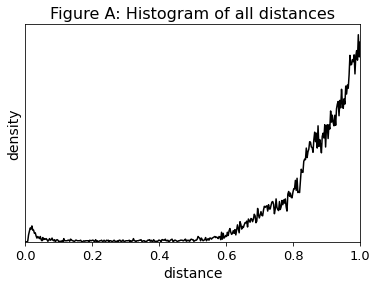

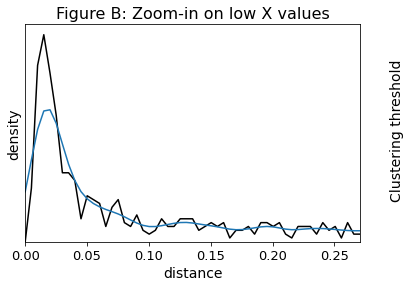

In [152]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def plot(xs, ys, title, xlabel, ylabel):
    figure = plt.figure()
    plt.plot(xs, ys, color='k')
    plt.tick_params(left=False, labelleft=False, labelsize=13)
    plt.ylim(0, plt.ylim()[1])
    plt.xlim(0, xs.max())
    plt.title(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    return figure

#histogram = vamb.vambtools.read_npz('histogram.npz')
xs = np.linspace(0, 1, 400)
fig_a = plot(xs[1:], histogram, "Figure A: Histogram of all distances", 'distance', 'density')
hist2 = histogram[0:120:2] + histogram[1:120:2]
fig_b = plot(xs[0:110:2], hist2[:55], "Figure B: Zoom-in on low X values", 'distance', 'density')
densities = calc_densities(hist2)
plt.plot(xs[0:110:2], densities[:55])
success,_,threshold = find_valley_ratio(densities, peak_valley_ratio=0.5)
plt.vlines(threshold, 0, plt.ylim()[1], linestyles='dotted')
plt.text(threshold, plt.ylim()[1]/5, "Clustering threshold", rotation=90, fontsize=14)

In [38]:
from DRBin.AAE_cluster import *
from Bio import SeqIO

import DRBin
import DRBin.utils
from DRBin import process

In [37]:
contig_length = {}
contig_id_idx = {}
contig_idx_id = {}
contigs = '/home/maog/data/metahit/contigs.fna'
for record in SeqIO.parse(contigs, "fasta"):
    contig_length[record.id] = len(record.seq)
    contig_idx_id[len(contig_id_idx)] = record.id
    contig_id_idx[record.id] = len(contig_id_idx)

In [5]:
output = '/home/maog/data/metahit'
res = perform_binning(output, contigs)
len(res.keys())

380

In [67]:
import collections
cluster = dict()
cluster = collections.defaultdict(set)
for k, v in res.items():
    for i in v:
        cluster[contig_idx_id[k]].add(contig_idx_id[i])
len(cluster.keys())

380

In [7]:
with open('/home/maog/data/metahit/AAE_cluster.tsv', 'w') as file:
    DRBin.utils.write_clusters(file, cluster)

In [8]:
reference_path = '/home/maog/data/metahit/reference.tsv'
#!head $reference_path # show first 10 lines of reference file
with open(reference_path) as reference_file:
    reference = DRBin.benchmark.Reference.from_file(reference_file)

taxonomy_path = '/home/maog/data/metahit/taxonomy.tsv'
#!head $taxonomy_path # show first 10 lines of reference file
with open(taxonomy_path) as taxonomy_file:
    reference.load_tax_file(taxonomy_file)

In [9]:
with open('/home/maog/data/metahit/AAE_cluster.tsv') as clusters_file:
    DRBin_clusters = DRBin.utils.read_clusters(clusters_file)
    DRBin_bins = DRBin.benchmark.Binning(DRBin_clusters, reference, minsize=100000)

In [10]:
print('DRBin bins:')
for rank in DRBin_bins.summary():
    print('\t'.join(map(str, rank)))

DRBin bins:
137	129	109	99	78	48	14	4	0
129	123	107	97	77	48	14	4	0
53	50	48	45	42	33	12	3	0


In [11]:
with open('/home/maog/data/metahit/vamb_cluster.tsv') as clusters_file:
    vamb_clusters = DRBin.utils.read_clusters(clusters_file)
    vamb_bins = DRBin.benchmark.Binning(vamb_clusters, reference, minsize=100000)

In [12]:
print('DRBin bins:')
for rank in vamb_bins.summary():
    print('\t'.join(map(str, rank)))

DRBin bins:
108	107	105	102	91	66	21	6	0
104	104	102	99	90	65	20	6	0
53	53	52	51	49	43	17	5	0


In [103]:
from hdbscan import HDBSCAN

labels = HDBSCAN(min_cluster_size=55).fit_predict(latent)

In [104]:
import collections
#clusters = dict()
clusters = collections.defaultdict(set)
for i in range(len(labels)):
    clusters[labels[i]]
len(clusters.keys())

187

In [105]:
for i in range(len(labels)):
    clusters[labels[i]].add(contig_idx_id[i])

In [106]:
len(clusters.keys())

187

In [107]:
with open('/home/maog/data/metahit/hdbscan_cluster.tsv', 'w') as file:
    DRBin.utils.write_clusters(file, clusters)

In [108]:
with open('/home/maog/data/metahit/hdbscan_cluster.tsv') as clusters_file:
    DRBin_clusters = DRBin.utils.read_clusters(clusters_file)
    DRBin_bins = DRBin.benchmark.Binning(DRBin_clusters, reference, minsize=100000)

In [109]:
print('DRBin bins:')
for rank in DRBin_bins.summary():
    print('\t'.join(map(str, rank)))

DRBin bins:
124	121	106	93	68	37	11	3	0
119	117	104	91	68	37	11	3	0
51	51	49	45	39	24	9	2	0
